In [1]:
import pandas as pd
import numpy as np
import vector
import os
from xgboost import XGBClassifier

import HH4b.utils as utils
from HH4b.utils import ShapeVar
import HH4b.plotting as plotting
import HH4b.postprocessing as postprocessing
from HH4b.postprocessing import Region

import hist
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

/Users/cmantill/miniconda3/envs/coffea/lib/python3.8/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [3]:
samples = {
    "2022": {
        "ttbar": [
            "TTto4Q",
            "TTtoLNu2Q",
            "TTto2L2Nu",
        ],
        "hh4b": [
            "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
        ],
        "data": [
            "JetMET_Run2022C",
            "JetMET_Run2022C_single",
            "JetMET_Run2022D",
        ],
        "novhhtobb": [
            "GluGluHto2B_PT-200_M-125",
            "VBFHto2B_M-125_dipoleRecoilOn",
        ],
        "vhtobb": [
            "WminusH_Hto2B_Wto2Q_M-125",
            "WplusH_Hto2B_Wto2Q_M-125",
            "ZH_Hto2B_Zto2Q_M-125",
            "ggZH_Hto2B_Zto2Q_M-125",
        ],
        "vbfhh4b": [
            "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
        ],
        "diboson": [
            "WW",
            "ZZ",
        ],
        "vjets": [
            "Wto2Q-3Jets_HT-200to400",
            "Wto2Q-3Jets_HT-400to600",
            "Wto2Q-3Jets_HT-600to800",
            "Wto2Q-3Jets_HT-800",
            "Zto2Q-4Jets_HT-200to400",
            "Zto2Q-4Jets_HT-400to600",
            "Zto2Q-4Jets_HT-600to800",
            "Zto2Q-4Jets_HT-800",
        ],
    },
    "2022EE": {
        "ttbar": [
            "TTto4Q",
            "TTtoLNu2Q",
            "TTto2L2Nu",
        ],
        "hh4b": [
            "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV",
        ],
        "data": [
            "JetMET_Run2022E",
            "JetMET_Run2022F",
            "JetMET_Run2022G",
        ],
        "novhhtobb": [
            "GluGluHto2B_PT-200_M-125",
            "VBFHto2B_M-125_dipoleRecoilOn",
        ],
        "qcd": [
            "QCD_HT-200to400",
            "QCD_HT-400to600",
            "QCD_HT-600to800",
            "QCD_HT-800to1000",
            "QCD_HT-1000to1200",
            "QCD_HT-1200to1500",
            "QCD_HT-1500to2000",
            "QCD_HT-2000",
        ],
        "vhtobb": [
            "WminusH_Hto2B_Wto2Q_M-125",
            "WplusH_Hto2B_Wto2Q_M-125",
            "ZH_Hto2B_Zto2Q_M-125",
            "ggZH_Hto2B_Zto2Q_M-125",
        ],
        "vbfhh4b": [
            "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
        ],
        "diboson": [
            "WW",
            "ZZ",
        ],
        "vjets": [
            "Wto2Q-3Jets_HT-200to400",
            "Wto2Q-3Jets_HT-400to600",
            "Wto2Q-3Jets_HT-600to800",
            "Wto2Q-3Jets_HT-800",
            "Zto2Q-4Jets_HT-200to400",
            "Zto2Q-4Jets_HT-400to600",
            "Zto2Q-4Jets_HT-600to800",
            "Zto2Q-4Jets_HT-800",
        ],
    },
    "2023-pre-BPix": {
        "data": [
            "JetMET_Run2023C",
        ],
    },
    "2023-BPix": {
        "data": [
            "JetMET_Run2023D",
        ],
    },
}

MAIN_DIR = "../../../"
dir_name = "24Mar2_v12_signal"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/{dir_name}/"
dirs = {path_to_dir: samples}

load_columns = [
    ("weight", 1),
    ("MET_pt", 1),
    ("nFatJets", 1),
    ("bbFatJetPt", 2),
    ("bbFatJetEta", 2),
    ("bbFatJetPhi", 2),
    ("bbFatJetMsd", 2),
    ("bbFatJetPNetMass", 2),
    ("bbFatJetPNetXbb", 2),
    ("bbFatJetTau3OverTau2", 2),
    ("bbFatJetPNetQCD0HF", 2),
    ("bbFatJetPNetQCD1HF", 2),
    ("bbFatJetPNetQCD2HF", 2),
]

# to-do change this to msd>30
filters = [
    [
        ("('bbFatJetPt', '0')", ">=", 300),
        ("('bbFatJetPt', '1')", ">=", 300),
        ("('bbFatJetMsd', '0')", "<=", 250),
        ("('bbFatJetMsd', '1')", "<=", 250),
        ("('bbFatJetMsd', '0')", ">=", 50),
        ("('bbFatJetMsd', '1')", ">=", 50),
        ("('MET_pt', '0')", "<=", 1000),
    ],
]

events_dict = {}
years = ["2022", "2022EE", "2023-pre-BPix", "2023-BPix"]
for year in years:
    events_dict[year] = {}
    for input_dir, samples in dirs.items():
        events_dict[year] = {
            **events_dict[year],
            **utils.load_samples(
                input_dir,
                samples[year],
                year,
                filters=filters,
                columns_mc=utils.format_columns(load_columns),
            ),
        }

Loading TTto2L2Nu
Loading TTtoLNu2Q
Loading TTto4Q
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG
Loading JetMET_Run2022C
Loading JetMET_Run2022D
Loading JetMET_Run2022C_single
Loading GluGluHto2B_PT-200_M-125
Loading VBFHto2B_M-125_dipoleRecoilOn
Loading WplusH_Hto2B_Wto2Q_M-125
Loading WminusH_Hto2B_Wto2Q_M-125
Loading ggZH_Hto2B_Zto2Q_M-125
Loading ZH_Hto2B_Zto2Q_M-125
Loading WW
Loading ZZ
Loading Wto2Q-3Jets_HT-800
Loading Wto2Q-3Jets_HT-400to600
Loading Zto2Q-4Jets_HT-200to400
Loading Wto2Q-3Jets_HT-600to800
Loading Wto2Q-3Jets_HT-200to400
Loading Zto2Q-4Jets_HT-800
Loading Zto2Q-4Jets_HT-600to800
Loading Zto2Q-4Jets_HT-400to600
Loading TTto2L2Nu
Loading TTtoLNu2Q
Loading TTto4Q
Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV
Loading JetMET_Run2022E
Loading JetMET_Run2022G
Loading JetMET_Run2022F
Loading GluGluHto2B_PT-200_M-125
Loading VBFHto2B_M-125_dipoleRecoilOn
Loading QCD_HT-2000
Loading QCD_HT-400to600
Loading QCD_HT-800to1000
Loading QCD

In [4]:
events_dict

{'2022': {'ttbar':           weight      MET_pt nFatJets  bbFatJetPt             bbFatJetEta  \
                 0           0        0           0           1           0   
  0       0.004440  142.075867        2  384.817261  552.101135    0.622559   
  1       0.034051  101.543358        2  380.885956  318.697540   -1.887939   
  2       0.011961  137.593781        2  645.933350  474.463745    1.232422   
  3       0.006516   57.360901        2  409.733643  454.496460    0.869629   
  4       0.004429   94.352806        2  351.204437  460.958679   -0.975586   
  ...          ...         ...      ...         ...         ...         ...   
  193129  0.014332   56.007236        2  439.735748  519.934082    0.140503   
  193130  0.015014   80.379517        2  400.452728  417.791718   -0.671509   
  193131  0.028018   44.222454        5  469.796509  377.368317    0.293152   
  193132  0.055977   52.729893        2  397.206726  324.401733   -2.145508   
  193133  0.017074   27.331942     

In [5]:
variables_not_in_bdt = [
    # not use PnetMass until we debug it
    # "H1PNetMass",
    # not use H2 mass to avoid correlations
    "H2Msd",
    # "H2PNetMass",
    # not use H2Xbb so that we can further cut on it
    "H2Xbb",
    # these sculpt the mass
    "H1_dRH2",
    "H1_dPhiH2",
    # no weight
    "weight",
    # no pt
    "H1Pt",
    "H2Pt",
]


def bdt_dataframe(events):
    h1 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 0],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 0],
            "eta": events["bbFatJetEta"].to_numpy()[:, 0],
            "M": events["bbFatJetMsd"].to_numpy()[:, 0],
        }
    )
    h2 = vector.array(
        {
            "pt": events["bbFatJetPt"].to_numpy()[:, 1],
            "phi": events["bbFatJetPhi"].to_numpy()[:, 1],
            "eta": events["bbFatJetEta"].to_numpy()[:, 1],
            "M": events["bbFatJetMsd"].to_numpy()[:, 1],
        }
    )
    hh = h1 + h2

    # bdt variables
    df = pd.DataFrame(
        {
            # dihiggs system
            "HHlogPt": np.log(hh.pt),
            "HHeta": hh.eta,
            "HHmass": hh.mass,
            # met in the event
            "MET": events.MET_pt[0],
            # fatjet tau32
            "H1T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 0],
            "H2T32": events["bbFatJetTau3OverTau2"].to_numpy()[:, 1],
            # fatjet mass
            "H1Msd": events["bbFatJetMsd"].to_numpy()[:, 0],
            "H2Msd": events["bbFatJetMsd"].to_numpy()[:, 1],
            # fatjet kinematics
            "H1Pt": h1.pt,
            "H2Pt": h2.pt,
            "H1logPt": np.log(h1.pt),
            "H2logPt": np.log(h2.pt),
            "H1eta": h1.eta,
            "H2eta": h2.eta,
            "H1_dRH2": h1.deltaR(h2),
            "H1_dPhiH2": h1.deltaphi(h2),
            # xbb
            "H1Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 0],
            "H2Xbb": events["bbFatJetPNetXbb"].to_numpy()[:, 1],
            "H1QCD1HF": events["bbFatJetPNetQCD1HF"].to_numpy()[:, 0],
            "H1QCD2HF": events["bbFatJetPNetQCD2HF"].to_numpy()[:, 0],
            "H1QCD0HF": events["bbFatJetPNetQCD0HF"].to_numpy()[:, 0],
            # ratios
            "H1Pt_HHmass": h1.pt / hh.mass,
            "H2Pt_HHmass": h2.pt / hh.mass,
            "H1Pt/H2Pt": h1.pt / h2.pt,
            # weight
            "weight": events["weight"].to_numpy()[:, 0],
        }
    )
    df.replace(np.inf, 10000, inplace=True)
    df.replace(-np.inf, 10000, inplace=True)

    return df

In [6]:
bdt_model = XGBClassifier()
bdt_model.load_model(fname=f"{MAIN_DIR}/../data/bdt_trainings_run3/boostedBDT_test.json")

events_dict_bdt = {}
for year in years:
    events_dict_bdt[year] = {}
    for key in events_dict[year].keys():
        df_events = bdt_dataframe(events_dict[year][key])
        bdt_score = bdt_model.predict_proba(df_events.drop(columns=variables_not_in_bdt))[:, 1]

        events_dict_bdt[year][key] = df_events
        events_dict_bdt[year][key]["bdt_score"] = bdt_score

In [7]:
events_dict_bdt["2022"]["data"]

HHlogPt     HHeta       HHmass        MET     H1T32     H2T32  \
0     3.999228 -2.246372  1664.283552  37.280865  0.957983  0.825415   
1     4.257970 -2.091913  1043.839442  18.706482  0.539056  0.748400   
2     3.602931  2.294385   656.908361  21.290993  0.851417  0.895349   
3     4.693759 -2.409763  1105.527419  80.100403  0.900247  0.800384   
4     4.570989 -2.131050   851.516231  46.035053  0.814834  0.846486   
...        ...       ...          ...        ...       ...       ...   
8328  4.972017  1.300975   931.963403  79.979462  0.519643  0.568657   
8329  3.709420 -1.406764  1156.768014  28.987755  0.839201  0.845934   
8330  3.589576 -4.858955  2317.481086  55.290386  0.705342  0.677761   
8331  6.280043 -0.431521  1633.597292  59.273617  0.781808  0.848646   
8332  5.742999 -0.047949   695.760877  30.104351  0.747947  0.784404   

         H1Msd      H2Msd        H1Pt        H2Pt  ...     H1Xbb     H2Xbb  \
0     116.5625   73.56250  420.722015  436.358826  ...  0.896484  0.000016   
1     125.1250   62.65625  324.606750  391.695953  ...  0.832031  0.000511   
2      70.8750   57.93750  309.639435  313.996399  ...  0.815430  0.021210   
3     153.2500   79.25000  586.292175  479.294342  ...  0.845703  0.064026   
4      89.1875   90.93750  423.139313  327.572113  ...  0.934570  0.000733   
...        ...        ...         ...         ...  ...       ...       ...   
8328  166.0000  122.75000  501.527344  359.650909  ...  0.966797  0.321777   
8329   77.6875   70.87500  336.948364  372.470703  ...  0.887207  0.007500   
8330  200.2500  229.50000  691.329041  720.085144  ...  0.940918  0.037201   
8331  106.1875  156.25000  381.726562  555.561157  ...  0.896973  0.085754   
8332   99.4375   67.62500  432.717987  309.401428  ...  0.854004  0.004028   

      H1QCD1HF  H1QCD2HF      H1QCD0HF  H1Pt_HHmass  H2Pt_HHmass  H1Pt/H2Pt  \
0     0.017242  0.084473  8.471310e-06     0.252795     0.262190   0.964165   
1     0.013336  0.153198  6.170012e-07     0.310974     0.375245   0.828721   
2     0.103699  0.079285  1.095980e-05     0.471359     0.477991   0.986124   
3     0.106995  0.044891  6.252527e-05     0.530328     0.433544   1.223240   
4     0.002434  0.062805  7.053131e-10     0.496925     0.384693   1.291744   
...        ...       ...           ...          ...          ...        ...   
8328  0.002644  0.030685  1.467561e-08     0.538141     0.385907   1.394484   
8329  0.012520  0.099854  3.383029e-07     0.291284     0.321993   0.904631   
8330  0.005074  0.053986  6.175833e-08     0.298311     0.310719   0.960066   
8331  0.009956  0.092285  5.210750e-07     0.233672     0.340085   0.687101   
8332  0.007404  0.138428  5.518086e-08     0.621935     0.444695   1.398565   

      weight  bdt_score  
0        1.0   0.000544  
1        1.0   0.022723  
2        1.0   0.002543  
3        1.0   0.001434  
4        1.0   0.007478  
...      ...        ...  
8328     1.0   0.047648  
8329     1.0   0.000565  
8330     1.0   0.000055  
8331     1.0   0.000357  
8332     1.0   0.034770  

[116380 rows x 26 columns]

Make a control plot to make sure the normalization is not super off

bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar']
{'2022': 7971.4, '2022EE': 26337.0, '2022All': 34308.0, '2023-pre-BPix': 17650.0, '2023-BPix': 9451.0, '2023All': 27101.0, '2022-2023': 61409.0, '2018': 59830.0, '2017': 41480.0, '2016': 36330.0, 'Run2': 137640.0}


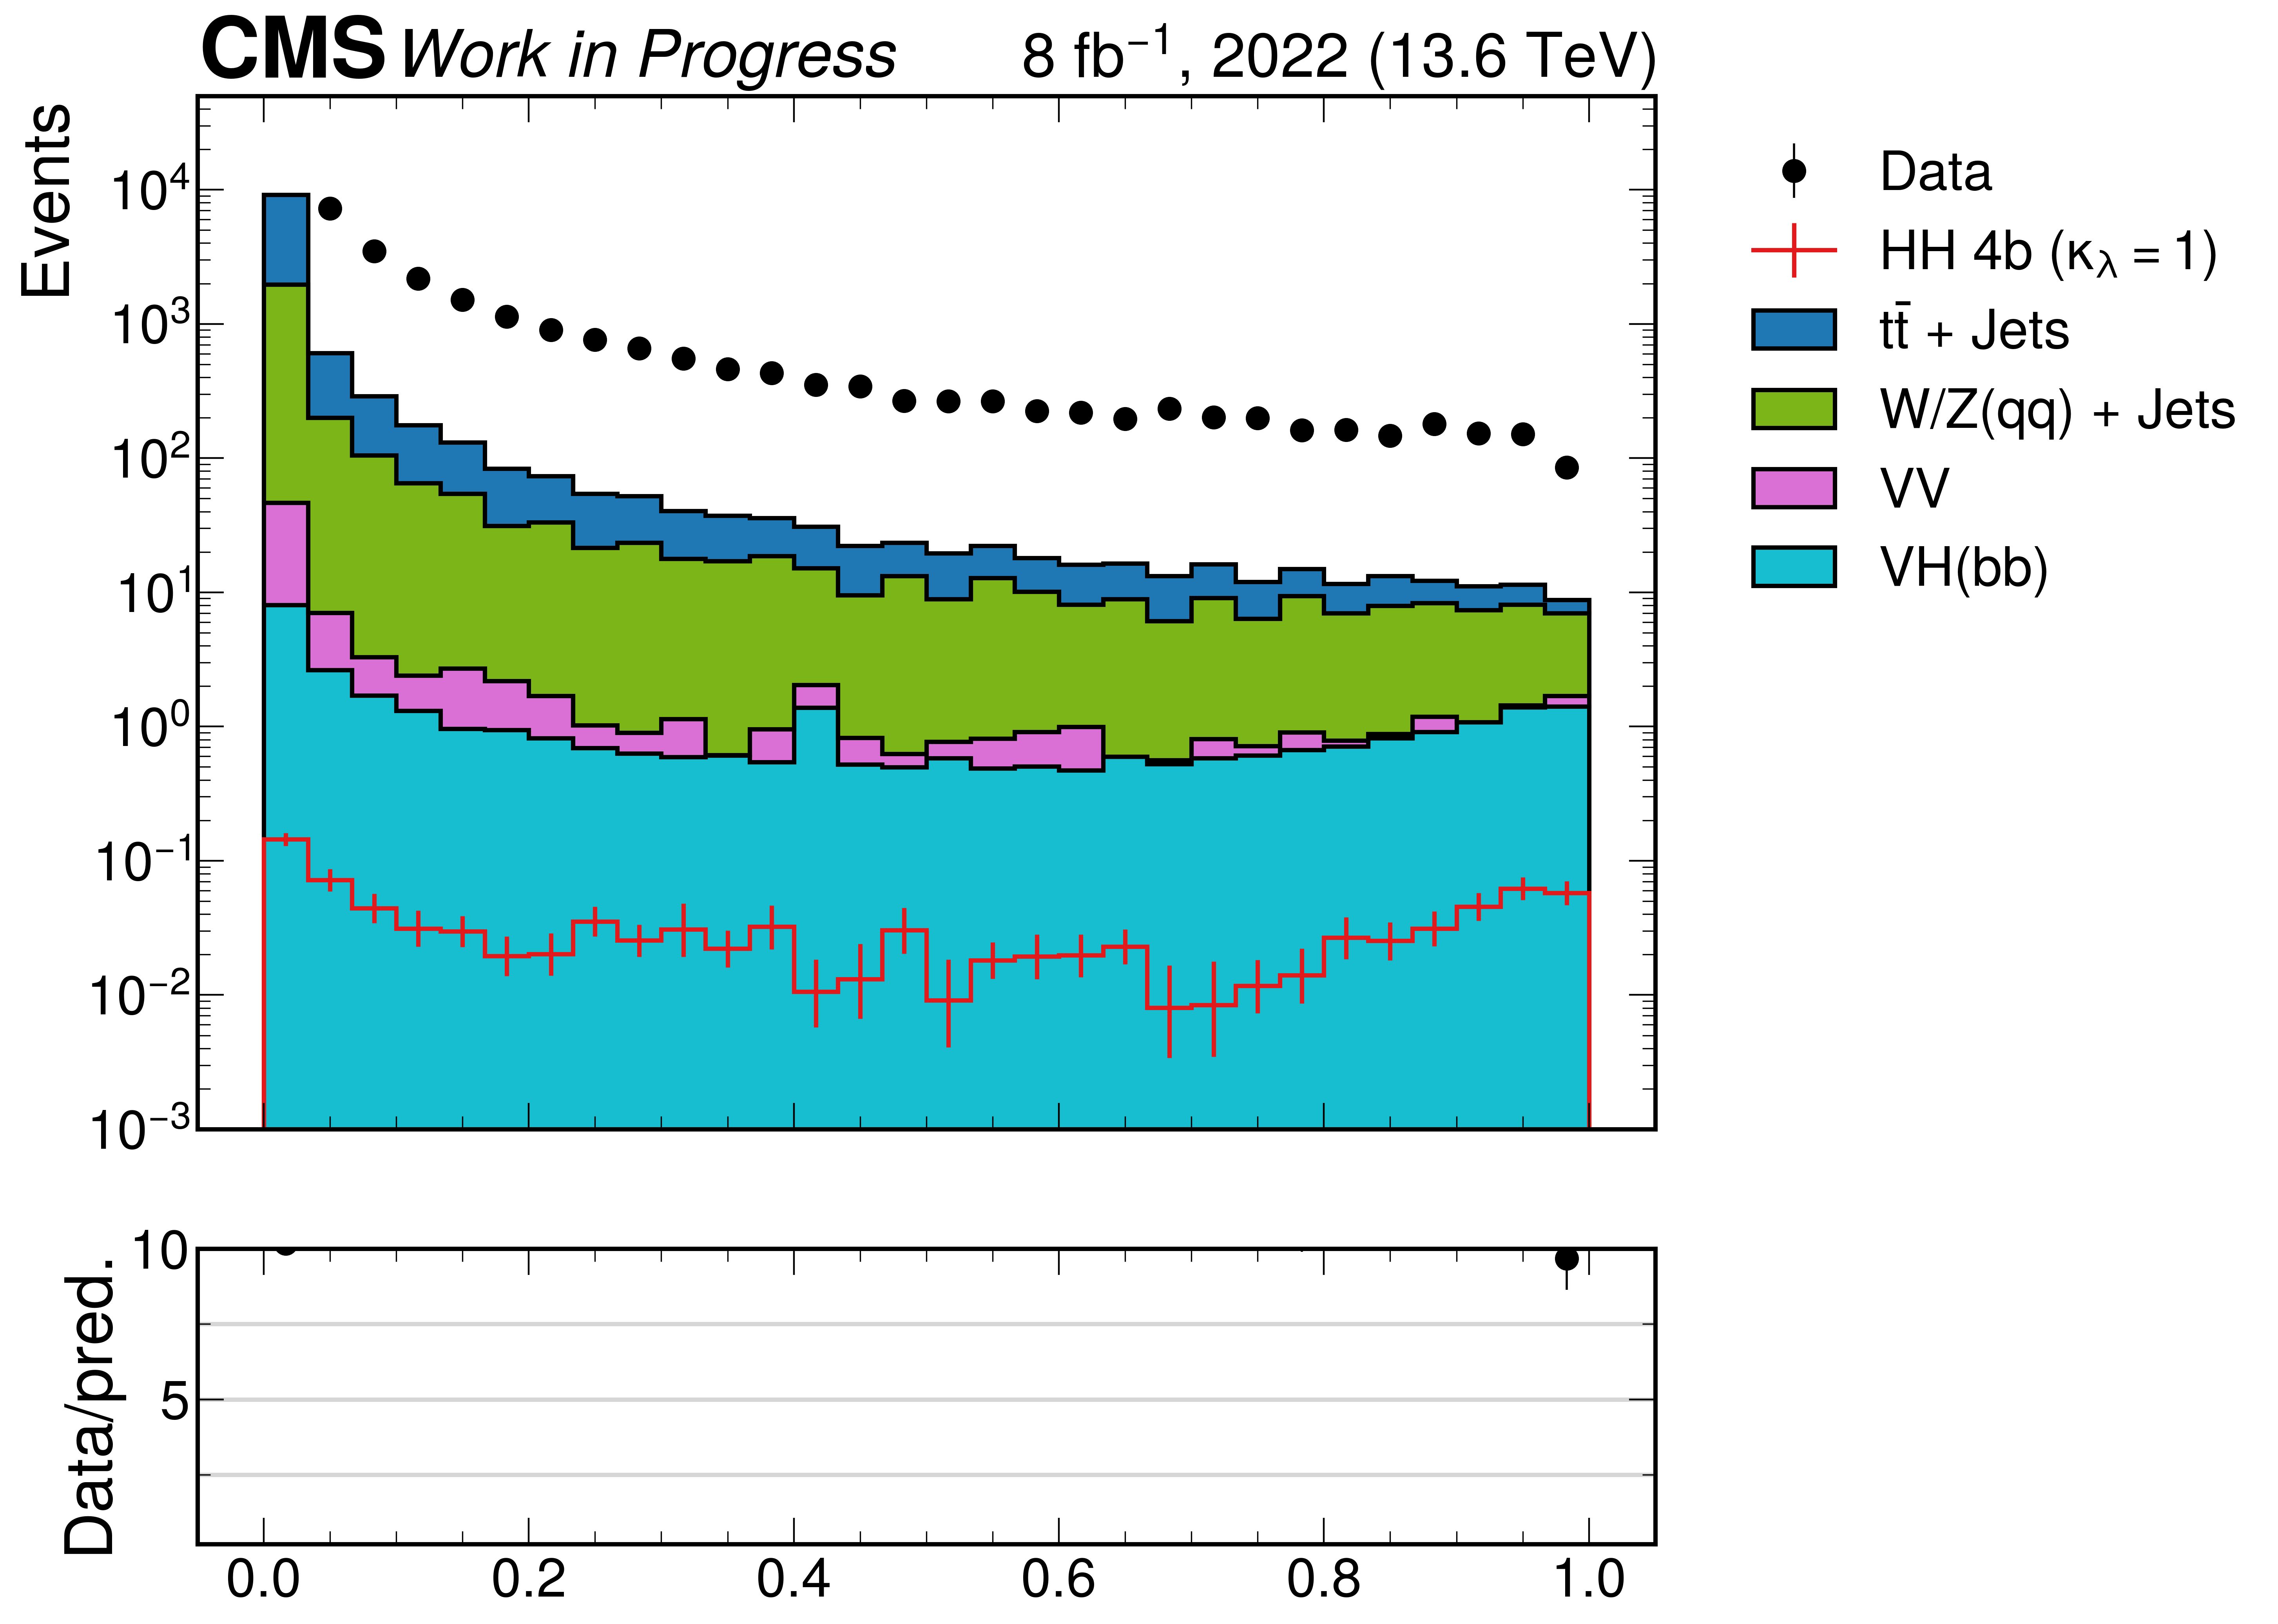

bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']
{'2022': 7971.4, '2022EE': 26337.0, '2022All': 34308.0, '2023-pre-BPix': 17650.0, '2023-BPix': 9451.0, '2023All': 27101.0, '2022-2023': 61409.0, '2018': 59830.0, '2017': 41480.0, '2016': 36330.0, 'Run2': 137640.0}


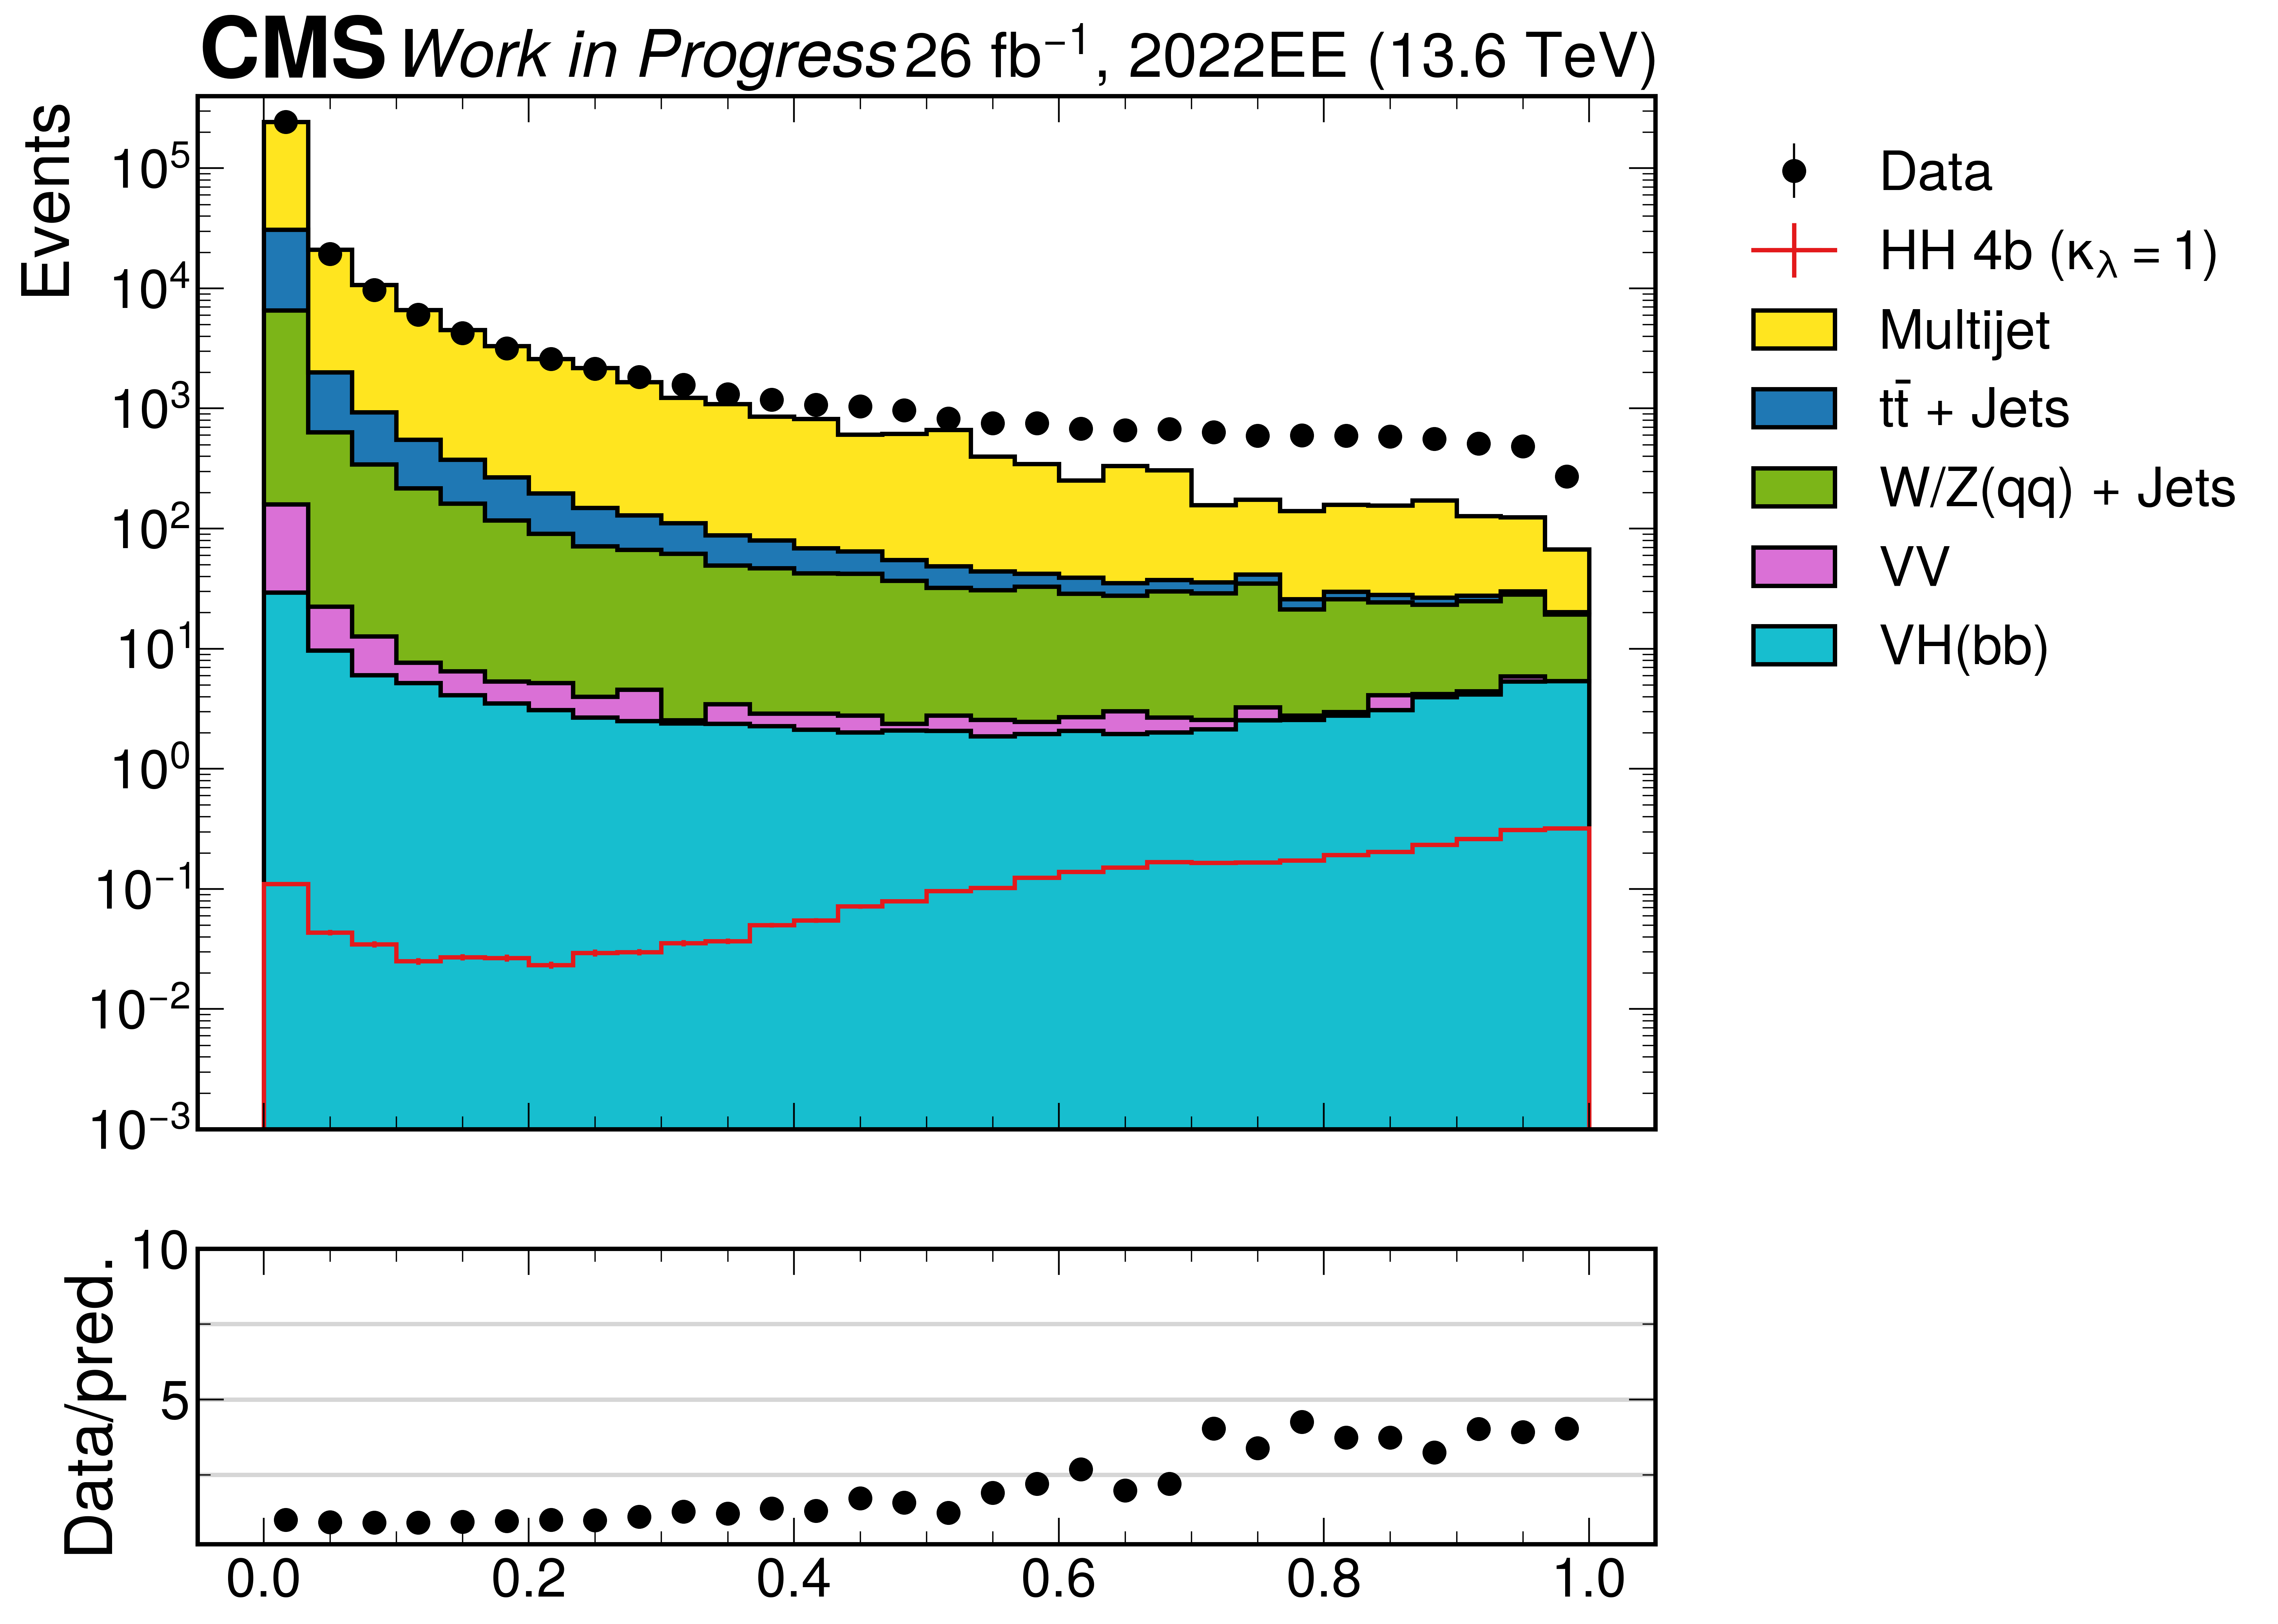

In [8]:
control_plot_vars = [
    ShapeVar(var="H2Msd", label=r"$m_{SD}^{2}$ (GeV)", bins=[30, 30, 250]),
    ShapeVar(var="bdt_score", label=r"BDT score", bins=[30, 0, 1]),
]

ylims = {
    "2022": 5e4,
    "2022EE": 4e5,
}

for year in ["2022", "2022EE"]:
    hists = {}
    for shape_var in control_plot_vars:
        if shape_var.var not in hists:
            hists[shape_var.var] = utils.singleVarHist(
                events_dict_bdt[year],
                shape_var,
                weight_key="weight",
            )

    bkgs = ["ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"]
    if year == "2022EE":
        bkgs += ["qcd"]

    plotting.ratioHistPlot(
        hists[shape_var.var],
        year,
        ["hh4b"],
        bkgs,
        name="test",
        show=True,
        log=True,
        plot_significance=False,
        significance_dir=shape_var.significance_dir,
        ratio_ylims=[0.2, 10],
        ylim=ylims[year],
    )

Look into BDT sculpting of H2Msd in data

In [9]:
cat_axis = hist.axis.StrCategory([], name="Sample", growth=True)
cut_axis = hist.axis.StrCategory([], name="Cut", growth=True)
h2_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"Higgs 2 mass [GeV]")

hist_h2 = hist.Hist(h2_mass_axis, cut_axis, cat_axis)
bdt_cuts = [0, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]

for key in ["qcd", "data"]:
    events = events_dict_bdt["2022EE"][key]
    h2_mass = events["H2Msd"]

    for cut in bdt_cuts:
        mask = events["bdt_score"] >= cut
        hist_h2.fill(h2_mass[mask], str(cut), key)

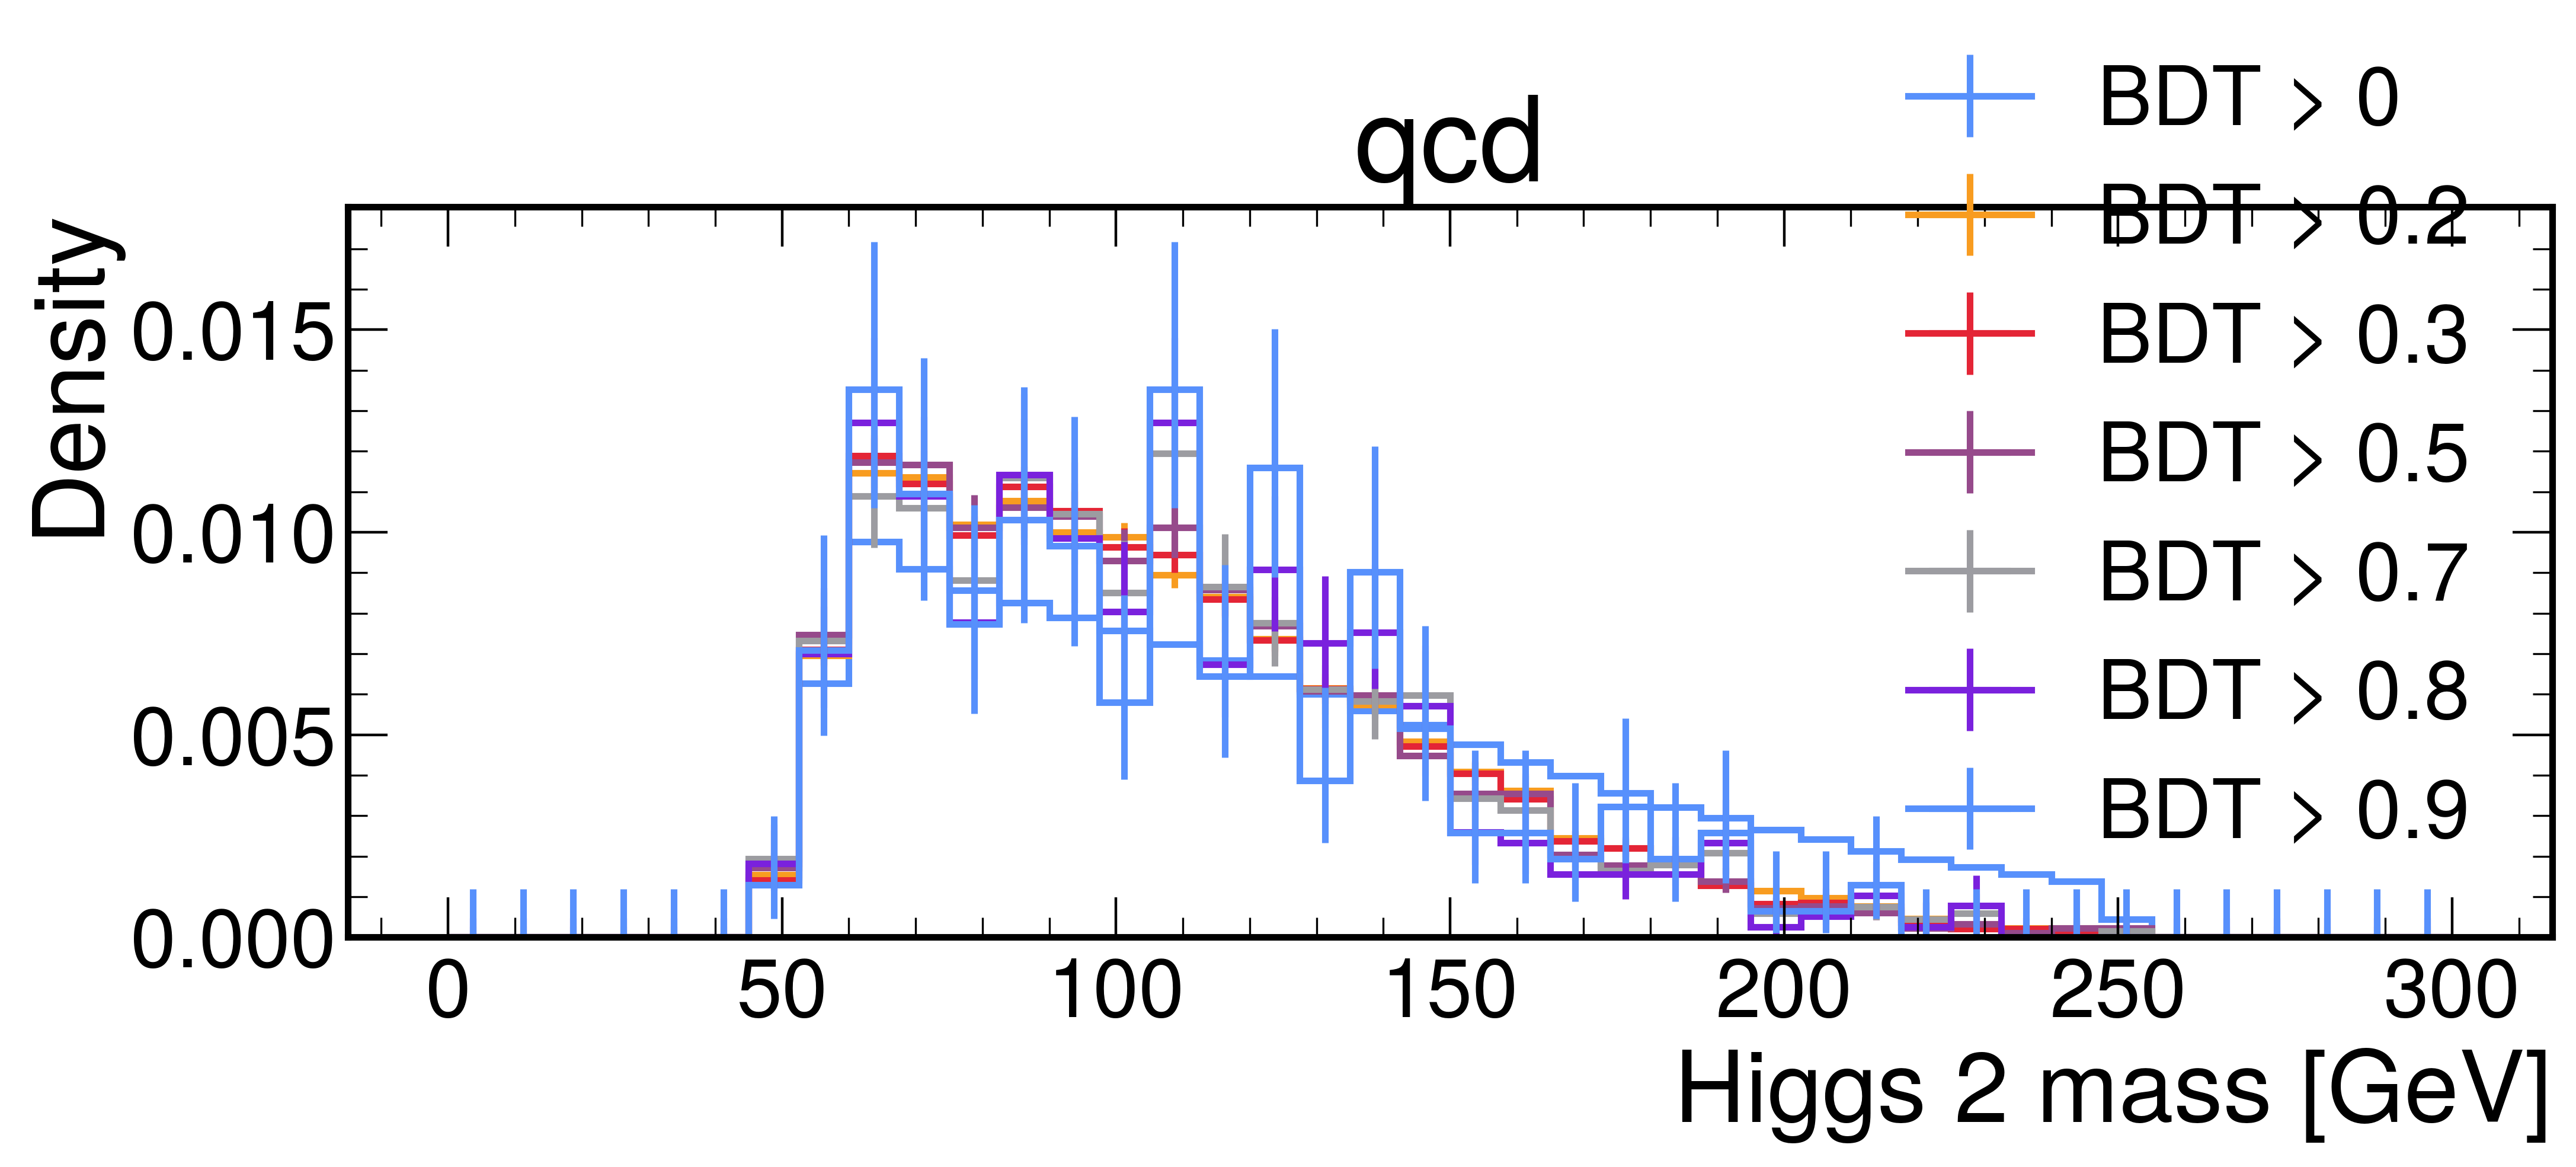

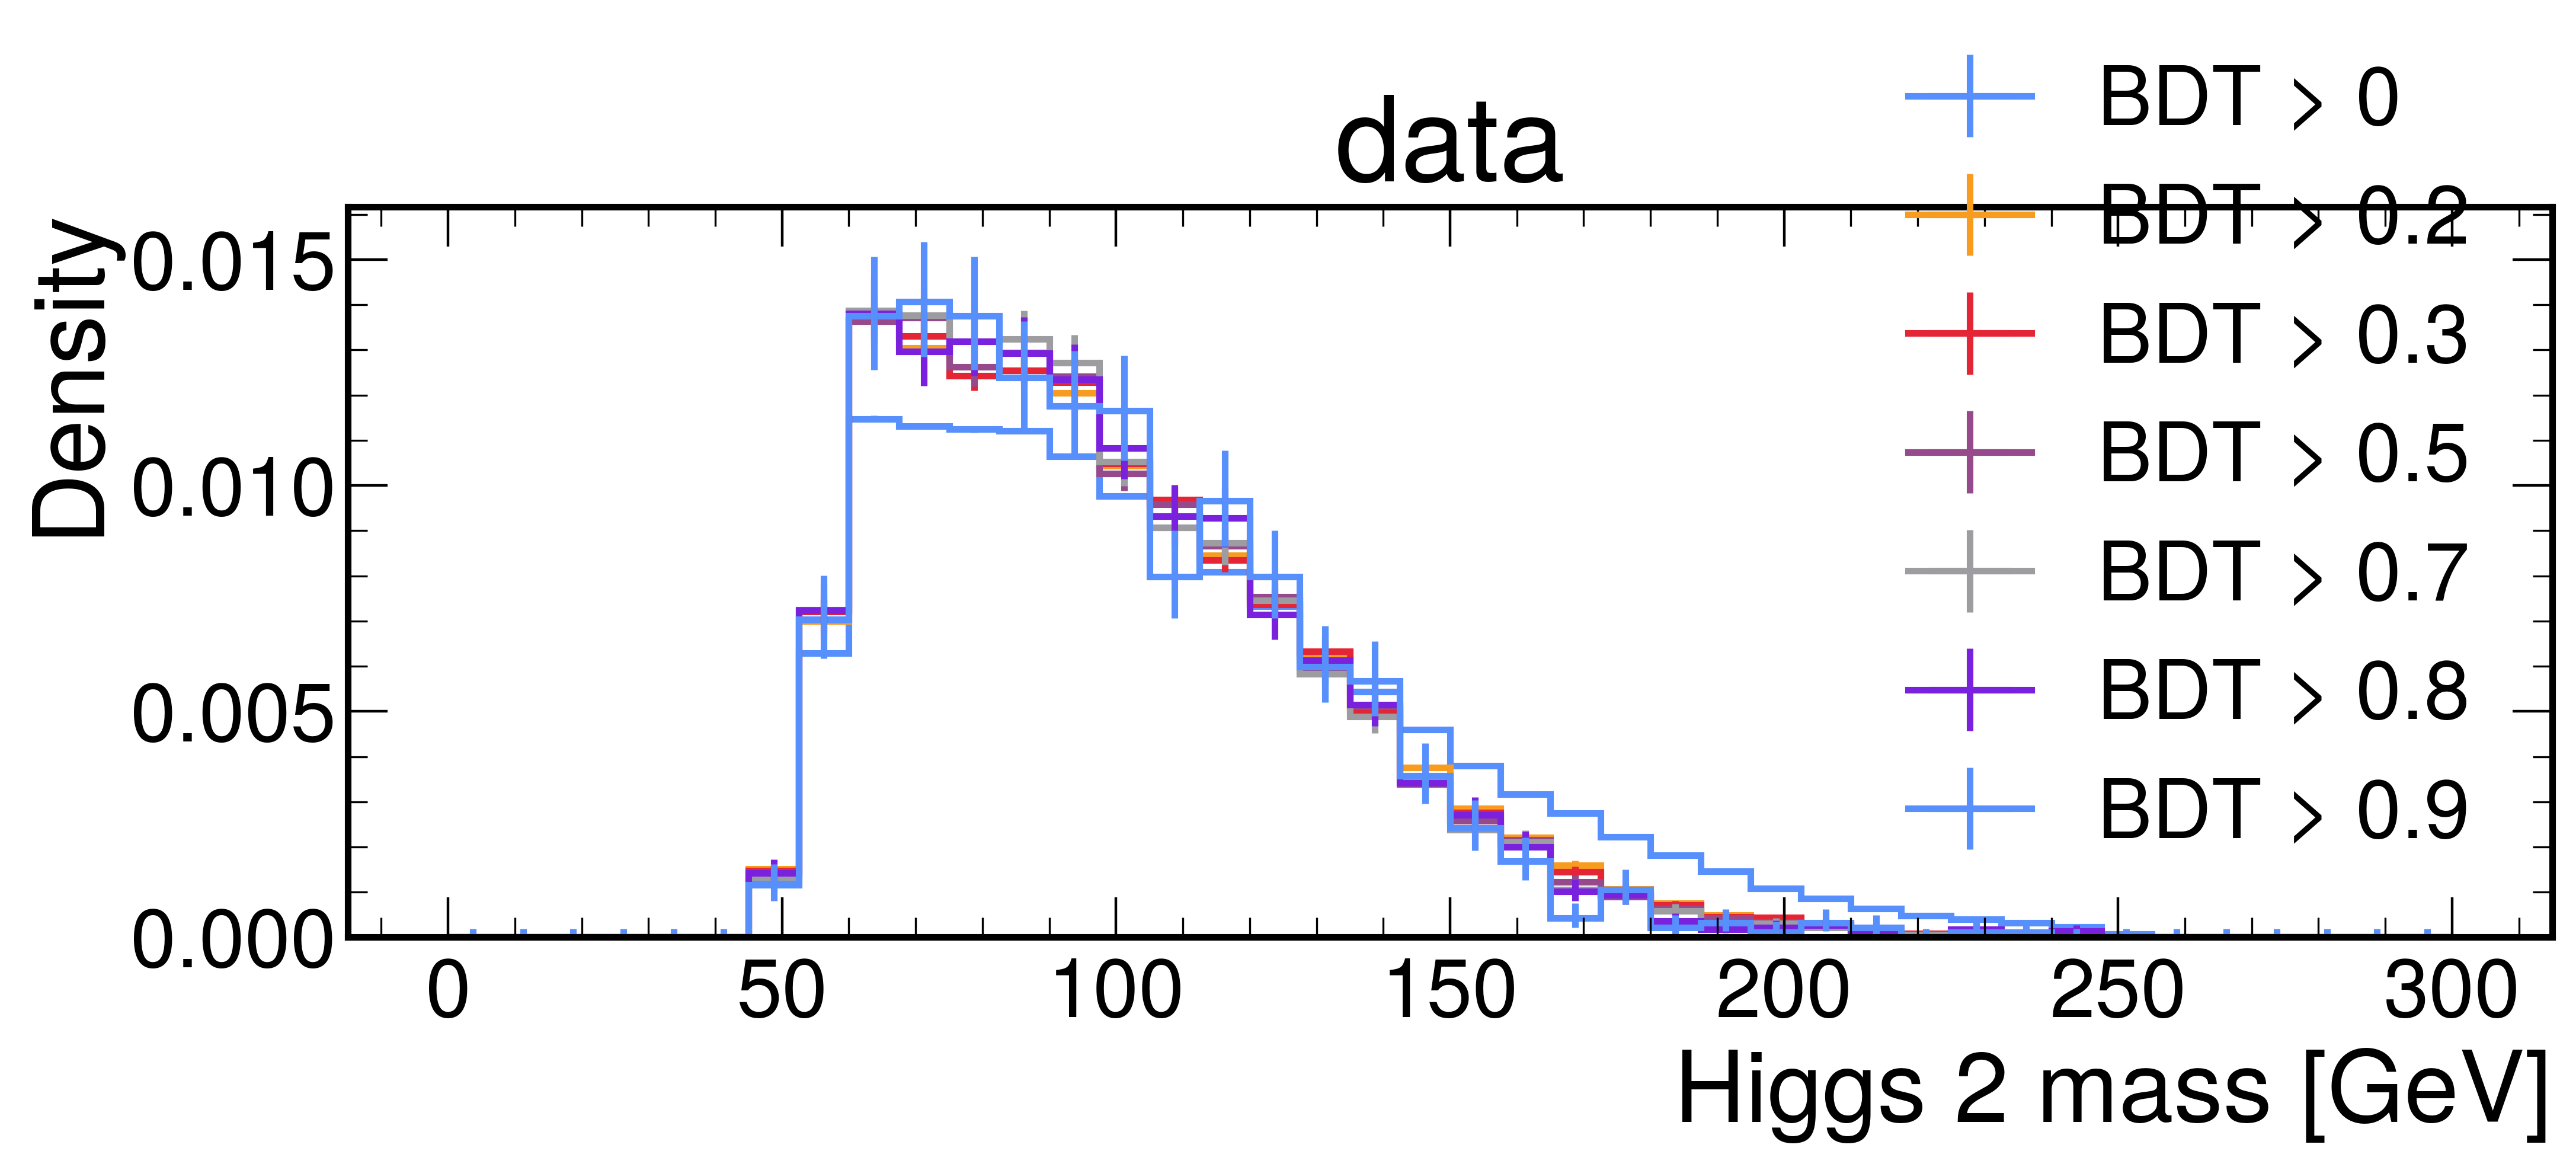

In [10]:
for key in ["qcd", "data"]:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    for cut in bdt_cuts:
        hep.histplot(
            hist_h2[{"Sample": key, "Cut": str(cut)}], lw=2, label=f"BDT > {cut}", density=True
        )
    ax.legend()
    ax.set_ylabel("Density")
    ax.set_title(key)

Create sideband in data
- Estimate number of events that pass BDT & H2Xbb selection

In [11]:
# create combined datasets
lumi_weight = (7971.4 + 26337.0) / 26337.0

events_dict_bdt_combined = {}
for key in events_dict_bdt["2022EE"].keys():
    if key not in ["qcd", "hh4b", "vbfhh4b"]:
        combined = pd.concat([events_dict_bdt["2022"][key], events_dict_bdt["2022EE"][key]])
    else:
        combined = events_dict_bdt["2022EE"][key].copy()
        combined["weight"] = combined["weight"] * lumi_weight
    events_dict_bdt_combined[key] = combined

In [12]:
events_dict_bdt_combined

{'ttbar':          HHlogPt     HHeta       HHmass         MET     H1T32     H2T32  \
 0       5.833622  1.024815   900.299331  142.075867  0.785139  0.861368   
 1       4.312043 -3.522833  1024.574478  101.543358  0.748895  0.845938   
 2       5.162634  1.534470  1951.610979  137.593781  0.844186  0.862241   
 3       3.864727  0.835937  1177.365339   57.360901  0.787740  0.910973   
 4       4.712122  0.247889  1180.571912   94.352806  0.630095  0.878136   
 ...          ...       ...          ...         ...       ...       ...   
 666910  3.243053  3.091482  1037.870701   66.099670  0.861678  0.810172   
 666911  1.411634 -5.463628   842.824466    7.393680  0.661259  0.477389   
 666912  4.461476  3.664649   704.057446  115.861946  0.835227  0.405778   
 666913  3.906111  3.180334   960.683003   45.301205  0.910557  0.614952   
 666914  2.858197 -5.263605   755.596506   22.816124  0.827087  0.756595   
 
             H1Msd     H2Msd        H1Pt        H2Pt  ...     H1Xbb     H2Xbb

In [13]:
def get_nevents_data(events, xbb_cut, bdt_cut):
    cut_xbb = events["H2Xbb"] > xbb_cut
    cut_bdt = events["bdt_score"] > bdt_cut
    cut_msd = (events["H2Msd"] > 50) & (events["H2Msd"] < 220)

    # get yield between 75-95
    cut_msd_0 = (events["H2Msd"] < 95) & (events["H2Msd"] > 75)

    # get yield between 135-155
    cut_msd_1 = (events["H2Msd"] < 155) & (events["H2Msd"] > 135)

    return np.sum(cut_msd_0 & cut_xbb & cut_bdt & cut_msd) + np.sum(
        cut_msd_1 & cut_xbb & cut_bdt & cut_msd
    )


def get_nevents_signal(events, xbb_cut, bdt_cut):
    cut_xbb = events["H2Xbb"] > xbb_cut
    cut_bdt = events["bdt_score"] > bdt_cut
    cut_msd = (events["H2Msd"] > 95) & (events["H2Msd"] < 135)

    # get yield
    # for signal, we use the lumi weight to scale the same signal by the total lumi (2022, 2022EE)
    return np.sum(events["weight"][cut_xbb & cut_bdt & cut_msd])


for xbb_cut in [0.8, 0.9, 0.95, 0.98]:
    figure_of_merits = []
    cuts = []
    for bdt_cut in np.arange(0.01, 1, 0.01):
        nevents_data = get_nevents_data(events_dict_bdt_combined["data"], xbb_cut, bdt_cut)
        nevents_signal = get_nevents_signal(events_dict_bdt_combined["hh4b"], xbb_cut, bdt_cut)

        figure_of_merit = 2 * np.sqrt(nevents_data) / nevents_signal

        if nevents_signal > 0.5:
            cuts.append(bdt_cut)
            figure_of_merits.append(figure_of_merit)
            print(
                f"Xbb_Cut: {xbb_cut}, BDT_Cut: {bdt_cut:.2f}, NBkg: {nevents_data}, NSig: {nevents_signal:.2f}, FOM: {figure_of_merit:.2f}"
            )

    if len(cuts) > 0:
        cuts = np.array(cuts)
        figure_of_merits = np.array(figure_of_merits)
        smallest = np.argmin(figure_of_merits)

        print(xbb_cut, cuts[smallest], figure_of_merits[smallest])

Xbb_Cut: 0.8, BDT_Cut: 0.01, NBkg: 441, NSig: 1.63, FOM: 25.77
Xbb_Cut: 0.8, BDT_Cut: 0.02, NBkg: 338, NSig: 1.62, FOM: 22.69
Xbb_Cut: 0.8, BDT_Cut: 0.03, NBkg: 281, NSig: 1.61, FOM: 20.76
Xbb_Cut: 0.8, BDT_Cut: 0.04, NBkg: 254, NSig: 1.61, FOM: 19.83
Xbb_Cut: 0.8, BDT_Cut: 0.05, NBkg: 225, NSig: 1.60, FOM: 18.71
Xbb_Cut: 0.8, BDT_Cut: 0.06, NBkg: 209, NSig: 1.60, FOM: 18.08
Xbb_Cut: 0.8, BDT_Cut: 0.07, NBkg: 193, NSig: 1.60, FOM: 17.40
Xbb_Cut: 0.8, BDT_Cut: 0.08, NBkg: 178, NSig: 1.59, FOM: 16.75
Xbb_Cut: 0.8, BDT_Cut: 0.09, NBkg: 161, NSig: 1.59, FOM: 15.98
Xbb_Cut: 0.8, BDT_Cut: 0.10, NBkg: 149, NSig: 1.58, FOM: 15.41
Xbb_Cut: 0.8, BDT_Cut: 0.11, NBkg: 143, NSig: 1.58, FOM: 15.13
Xbb_Cut: 0.8, BDT_Cut: 0.12, NBkg: 138, NSig: 1.58, FOM: 14.89
Xbb_Cut: 0.8, BDT_Cut: 0.13, NBkg: 132, NSig: 1.58, FOM: 14.59
Xbb_Cut: 0.8, BDT_Cut: 0.14, NBkg: 126, NSig: 1.57, FOM: 14.27
Xbb_Cut: 0.8, BDT_Cut: 0.15, NBkg: 115, NSig: 1.57, FOM: 13.66
Xbb_Cut: 0.8, BDT_Cut: 0.16, NBkg: 110, NSig: 1.57, FOM

pass
bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']
{'2022': 7971.4, '2022EE': 26337.0, '2022All': 34308.0, '2023-pre-BPix': 17650.0, '2023-BPix': 9451.0, '2023All': 27101.0, '2022-2023': 61409.0, '2018': 59830.0, '2017': 41480.0, '2016': 36330.0, 'Run2': 137640.0}


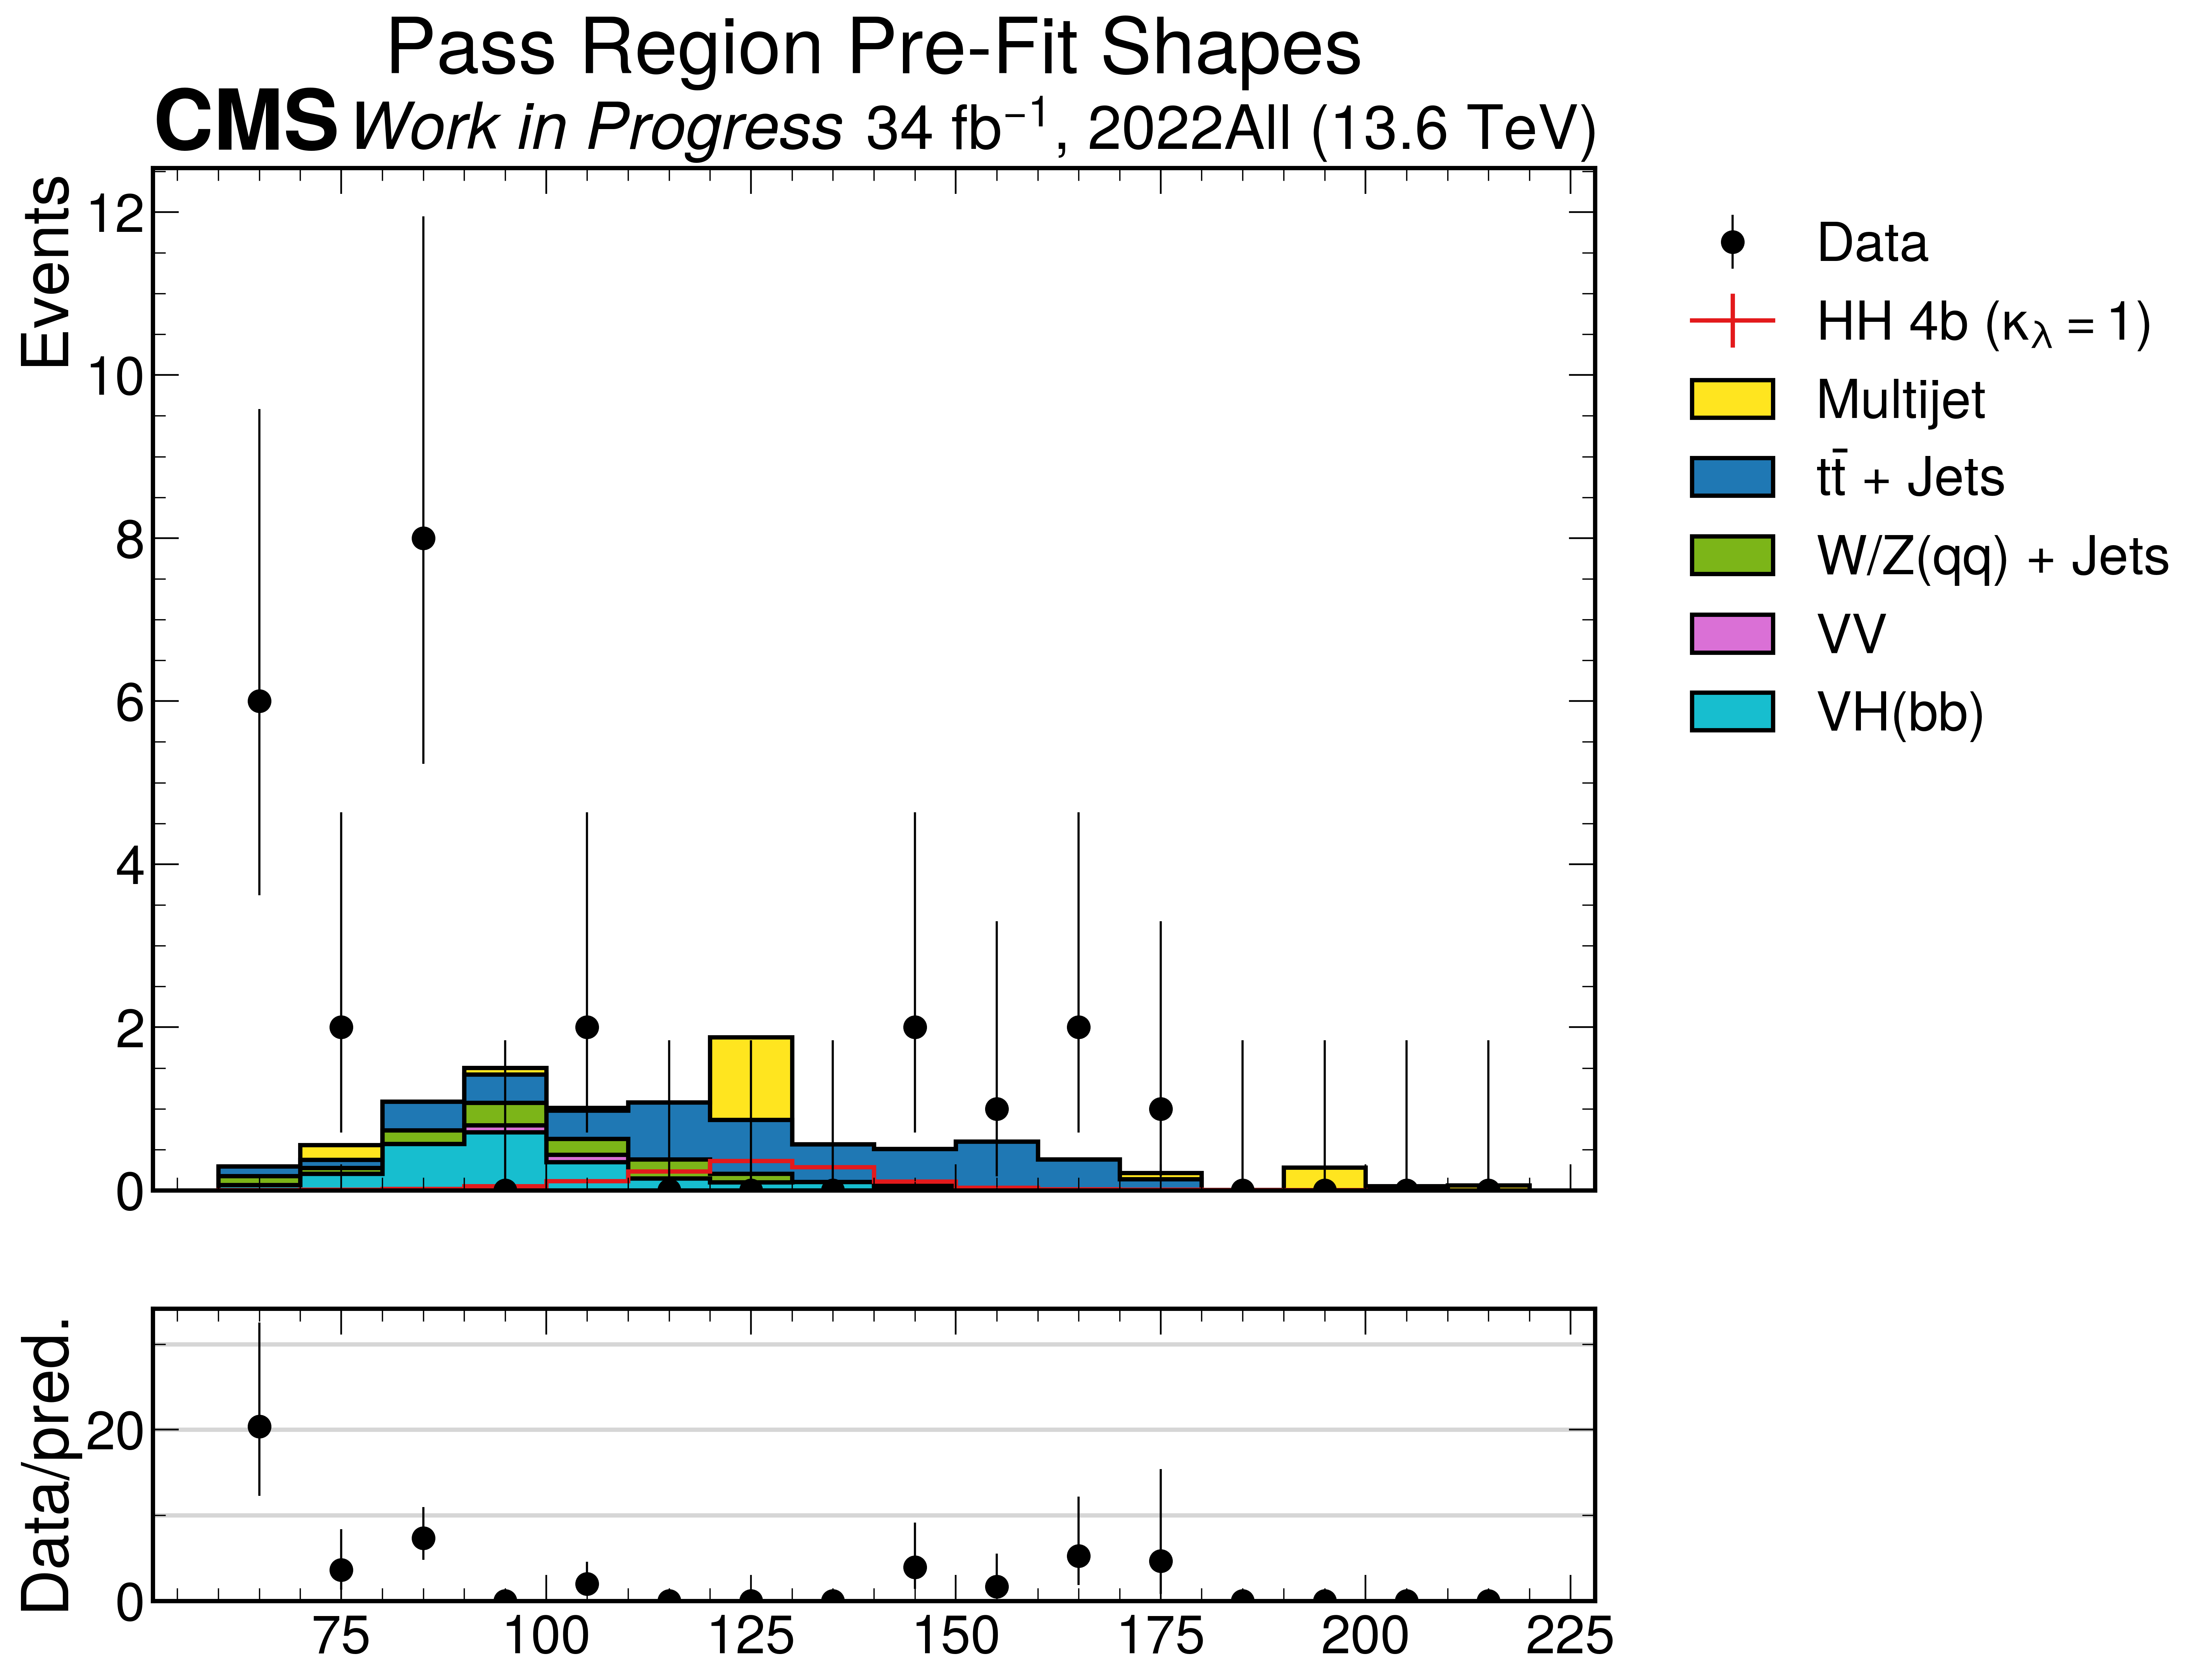

fail
bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']
{'2022': 7971.4, '2022EE': 26337.0, '2022All': 34308.0, '2023-pre-BPix': 17650.0, '2023-BPix': 9451.0, '2023All': 27101.0, '2022-2023': 61409.0, '2018': 59830.0, '2017': 41480.0, '2016': 36330.0, 'Run2': 137640.0}


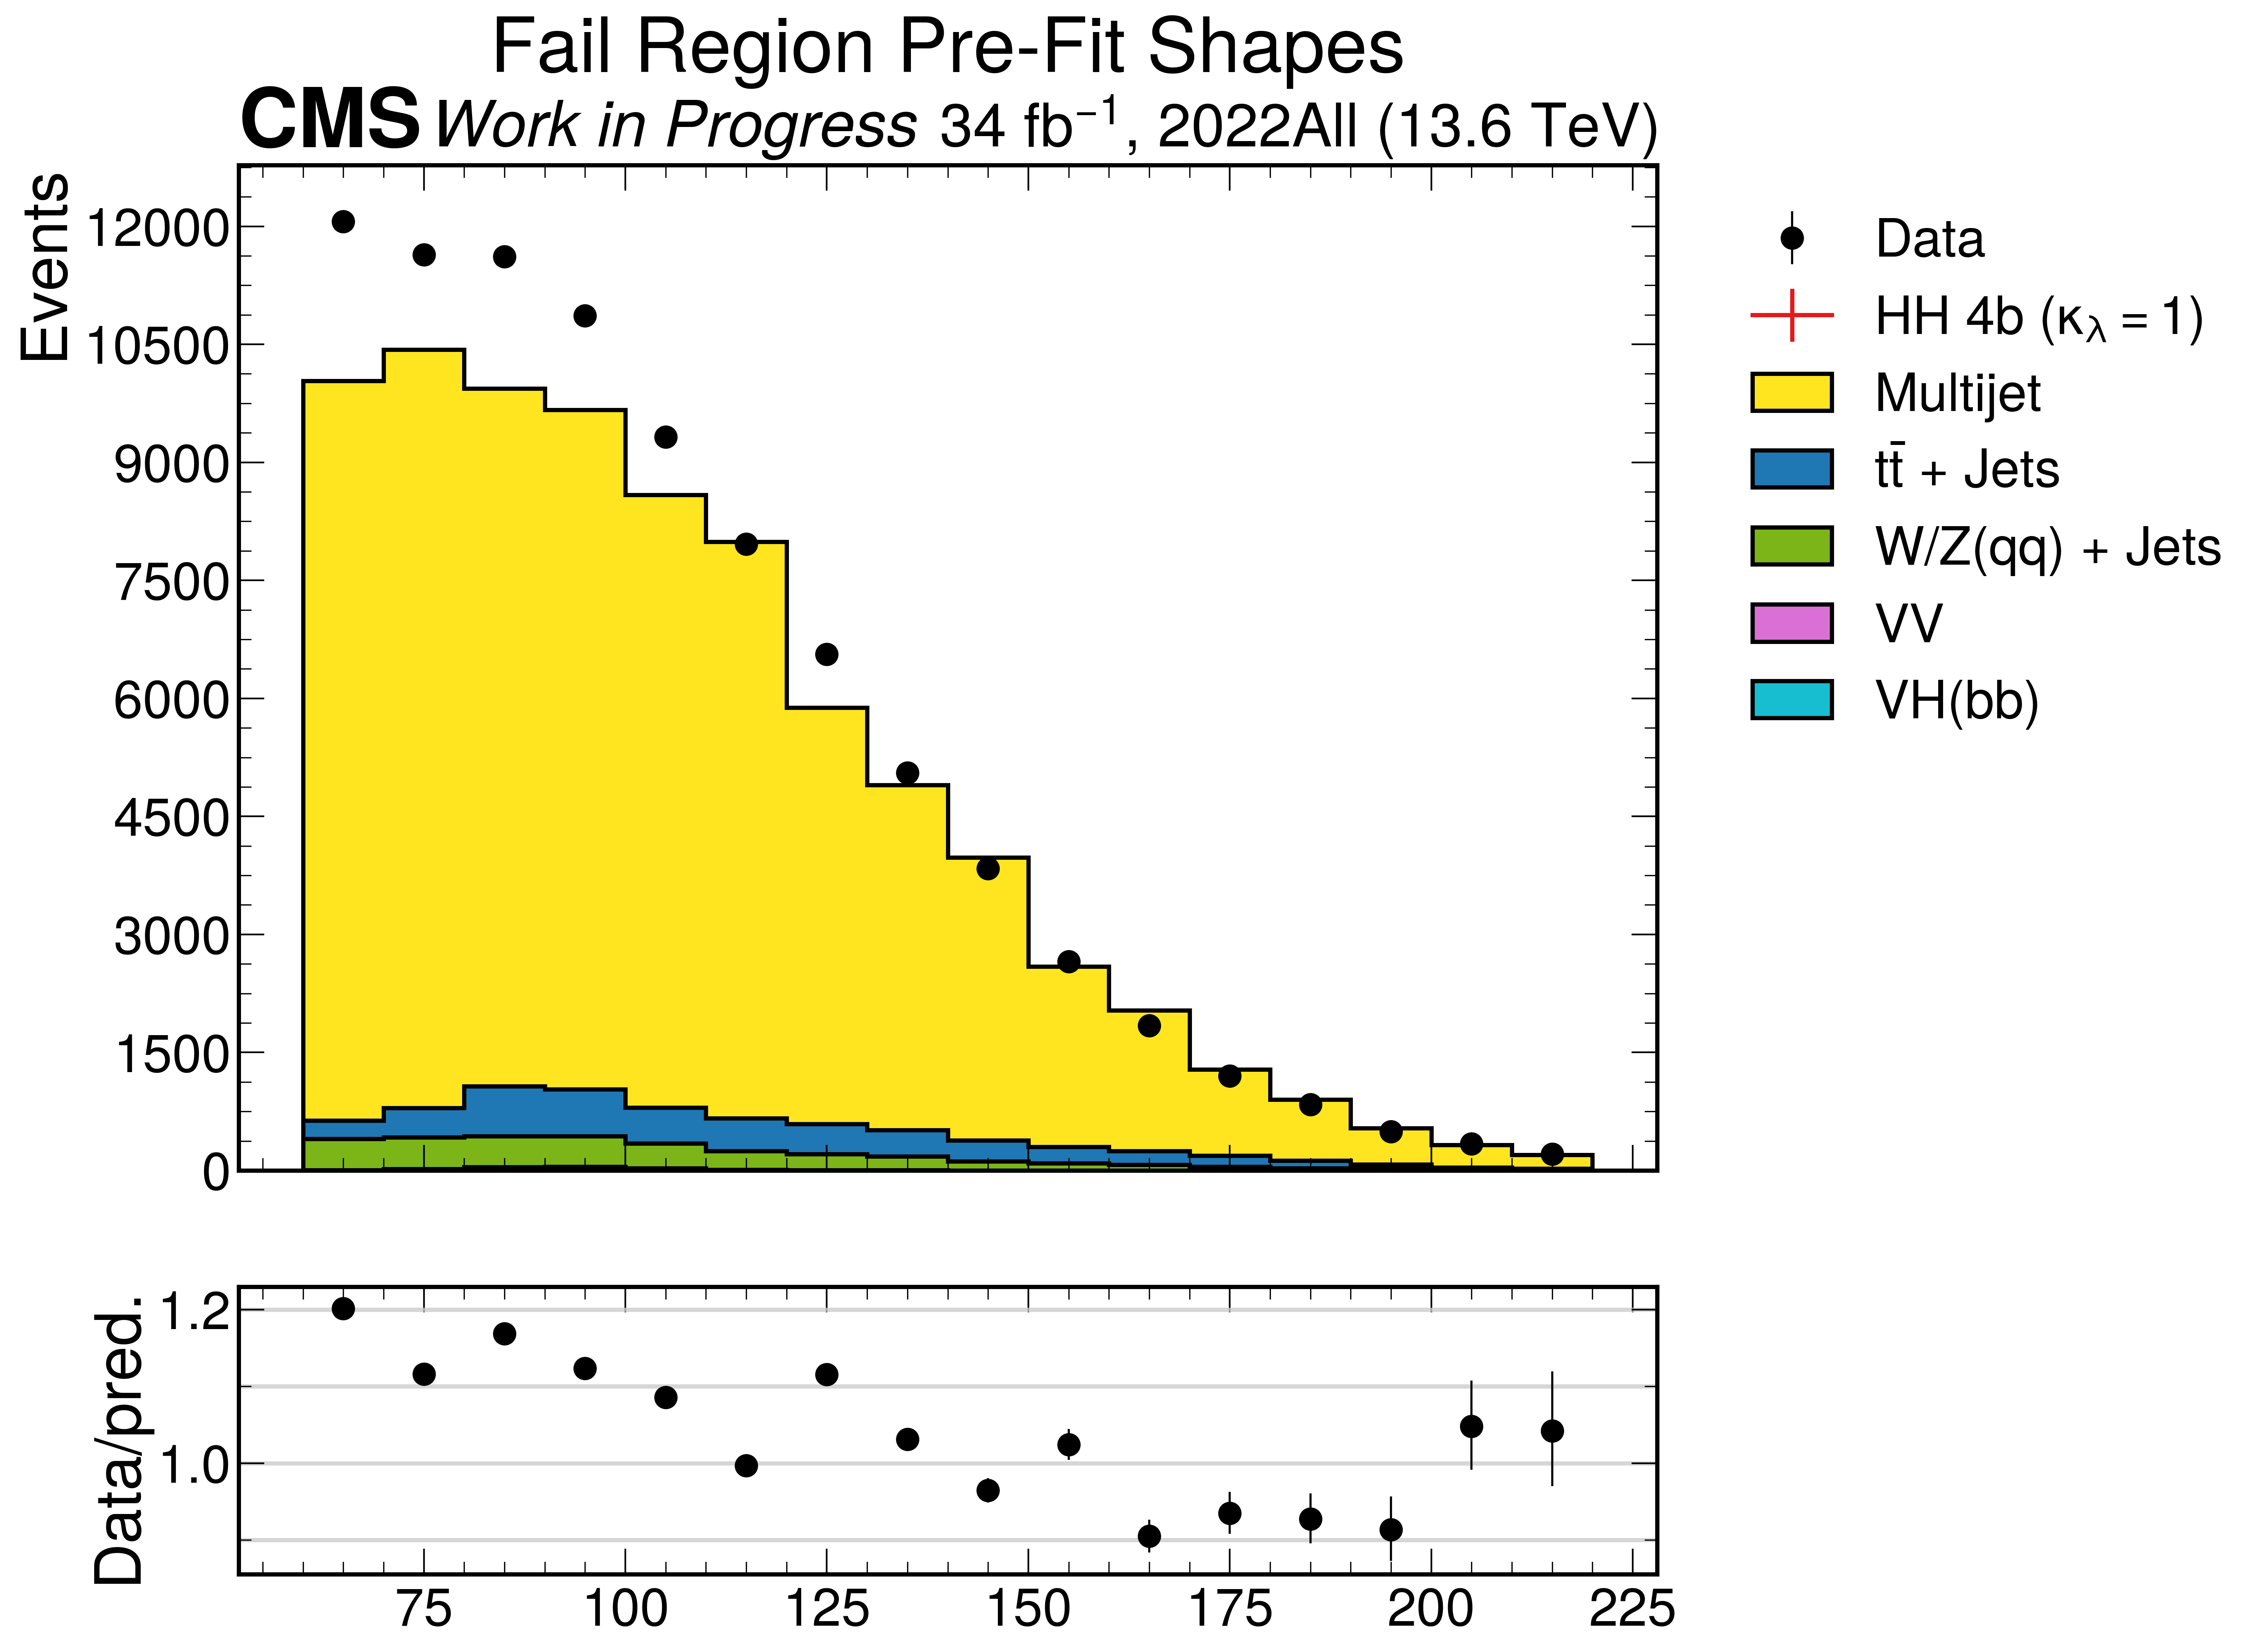

In [21]:
# got yields similar to cut based
# txbb_cut = 0.95
# bdt_cut = 0.05

txbb_cut = 0.9
bdt_cut = 0.62

# txbb_cut = 0.8
# bdt_cut = 0.72

# txbb_cut = 0.95
# bdt_cut = 0.62

selection_regions = {
    "pass": Region(
        cuts={
            "H2Xbb": [txbb_cut, 1],
            "bdt_score": [bdt_cut, 1],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H2Xbb": [0, txbb_cut],
            "bdt_score": [0.03, 1],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [16, 60, 220],
    reg=True,
    blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24/"
year = "2022All"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined,
    bb_masks=None,
    year="2022All",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)

pass
bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']
{'2022': 7971.4, '2022EE': 26337.0, '2022All': 34308.0, '2023-pre-BPix': 17650.0, '2023-BPix': 9451.0, '2023All': 27101.0, '2022-2023': 61409.0, '2018': 59830.0, '2017': 41480.0, '2016': 36330.0, 'Run2': 137640.0}


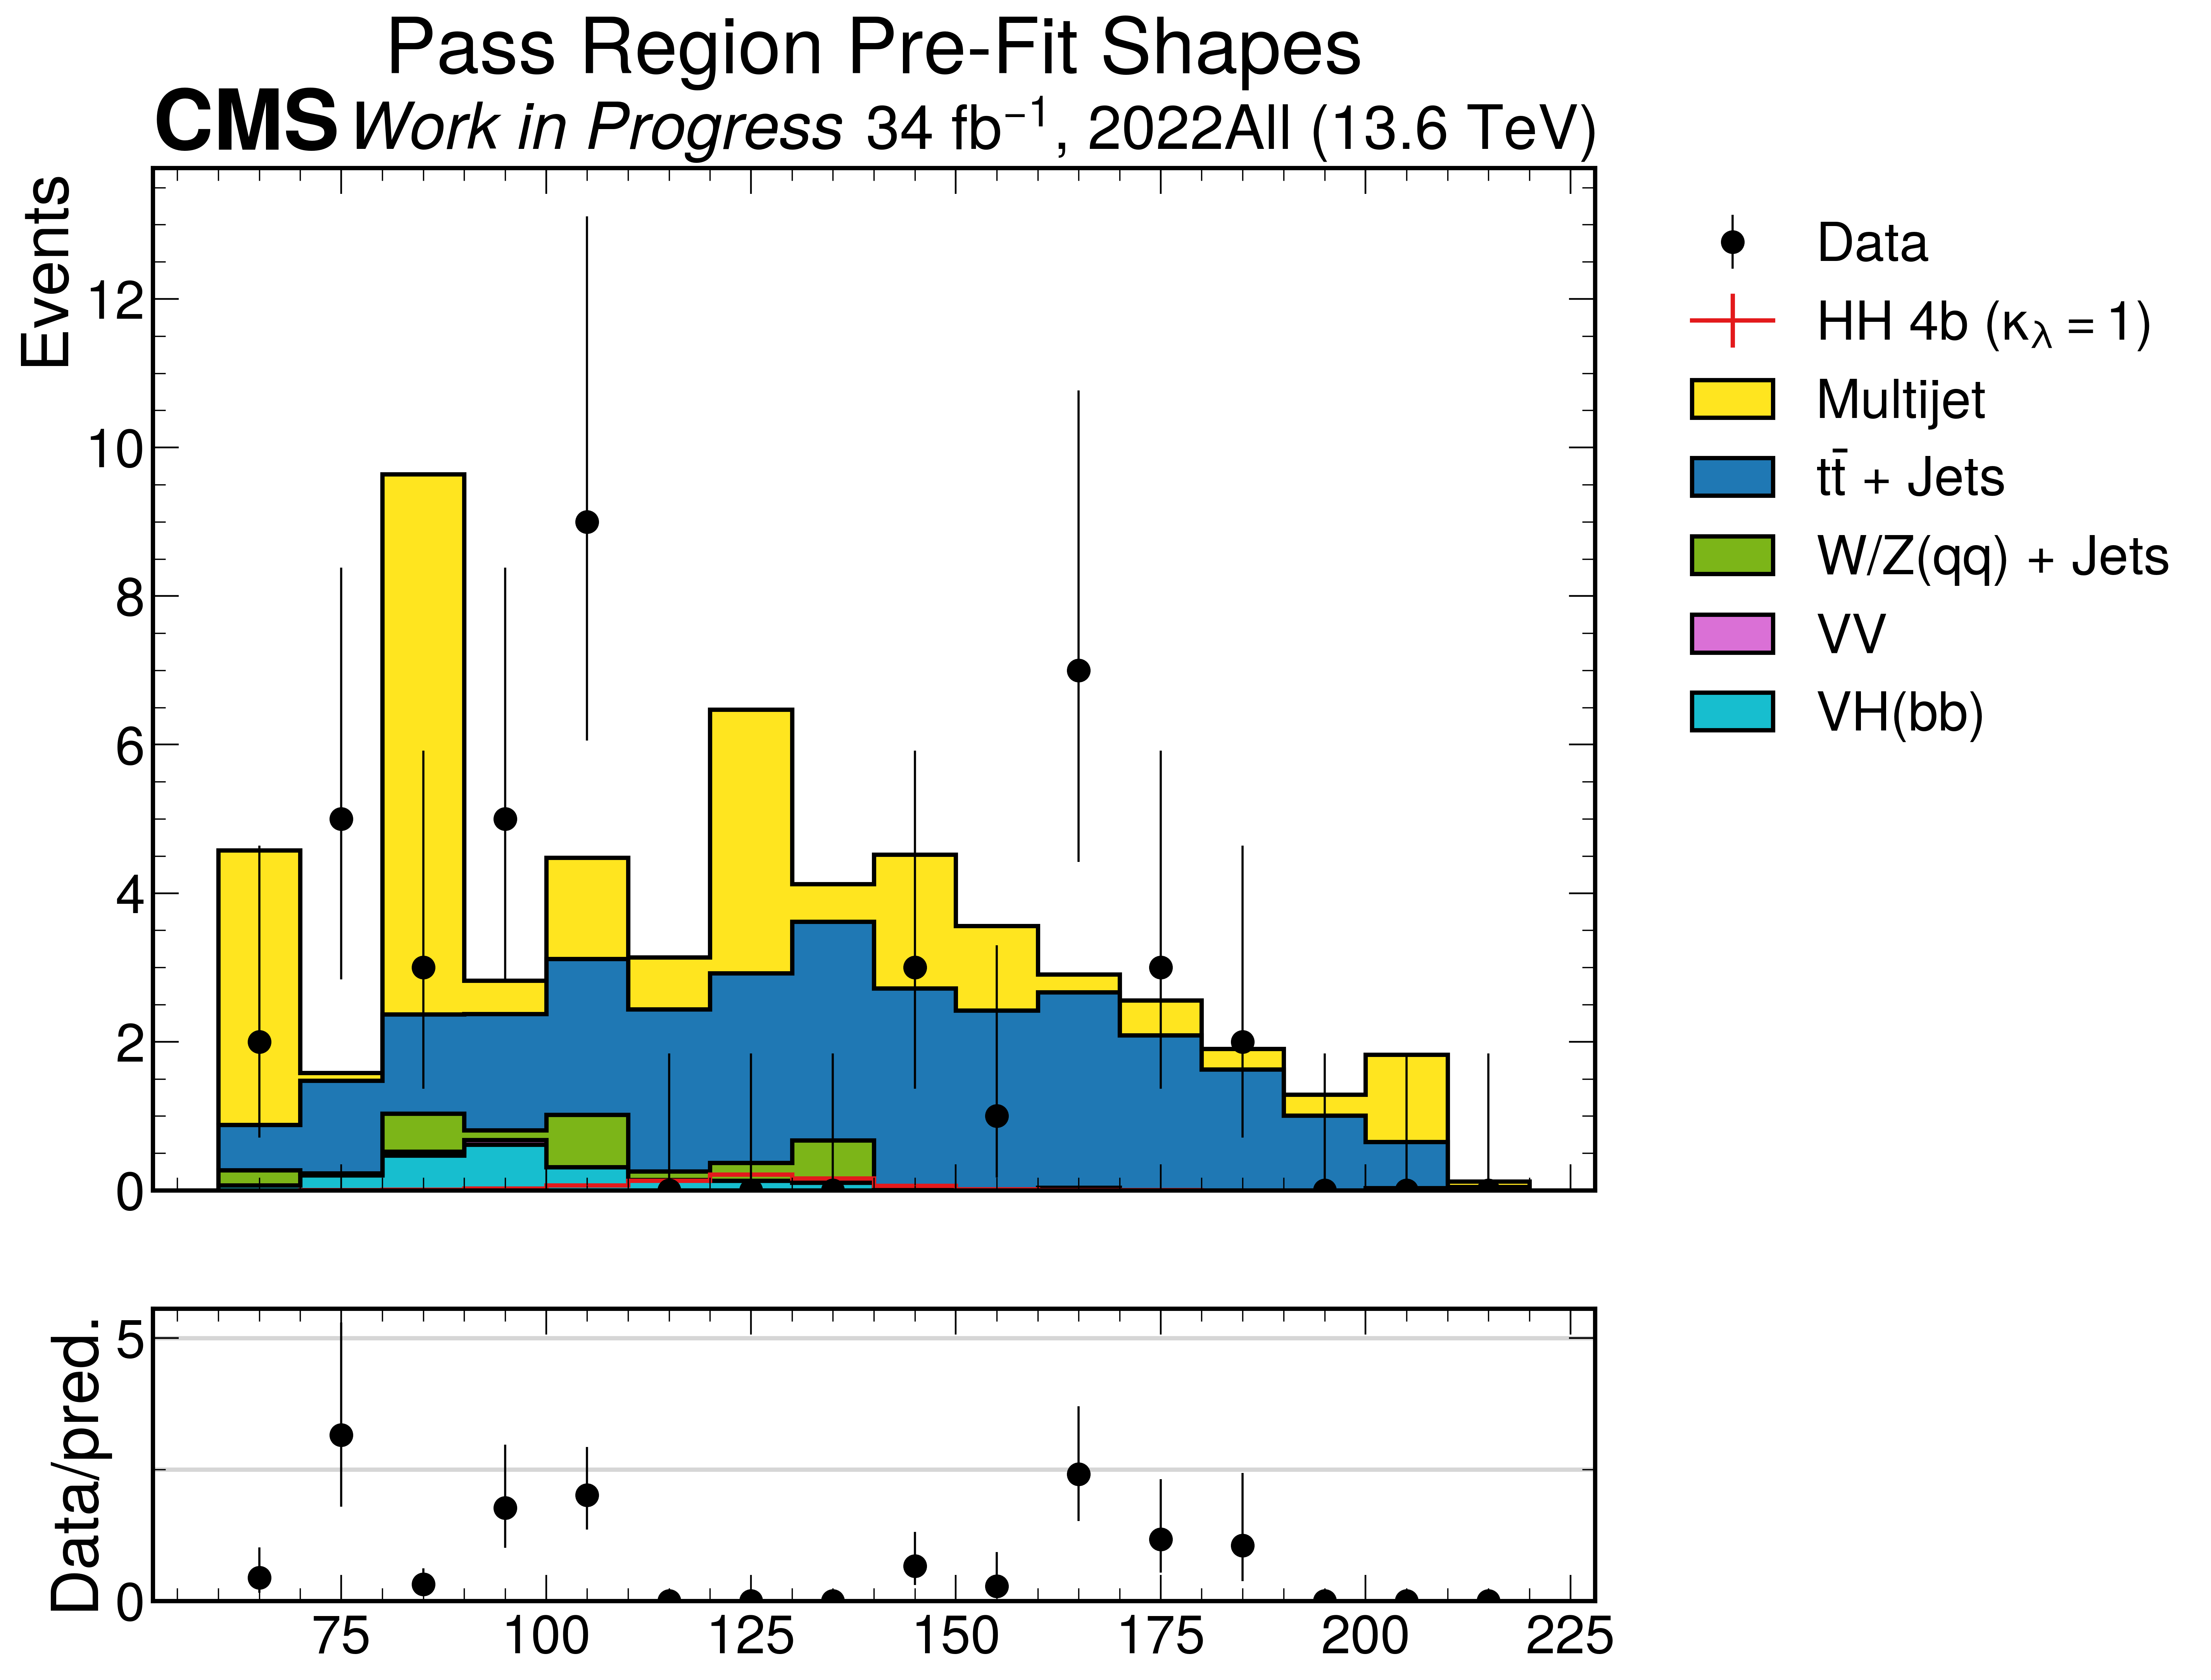

fail
bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']
{'2022': 7971.4, '2022EE': 26337.0, '2022All': 34308.0, '2023-pre-BPix': 17650.0, '2023-BPix': 9451.0, '2023All': 27101.0, '2022-2023': 61409.0, '2018': 59830.0, '2017': 41480.0, '2016': 36330.0, 'Run2': 137640.0}


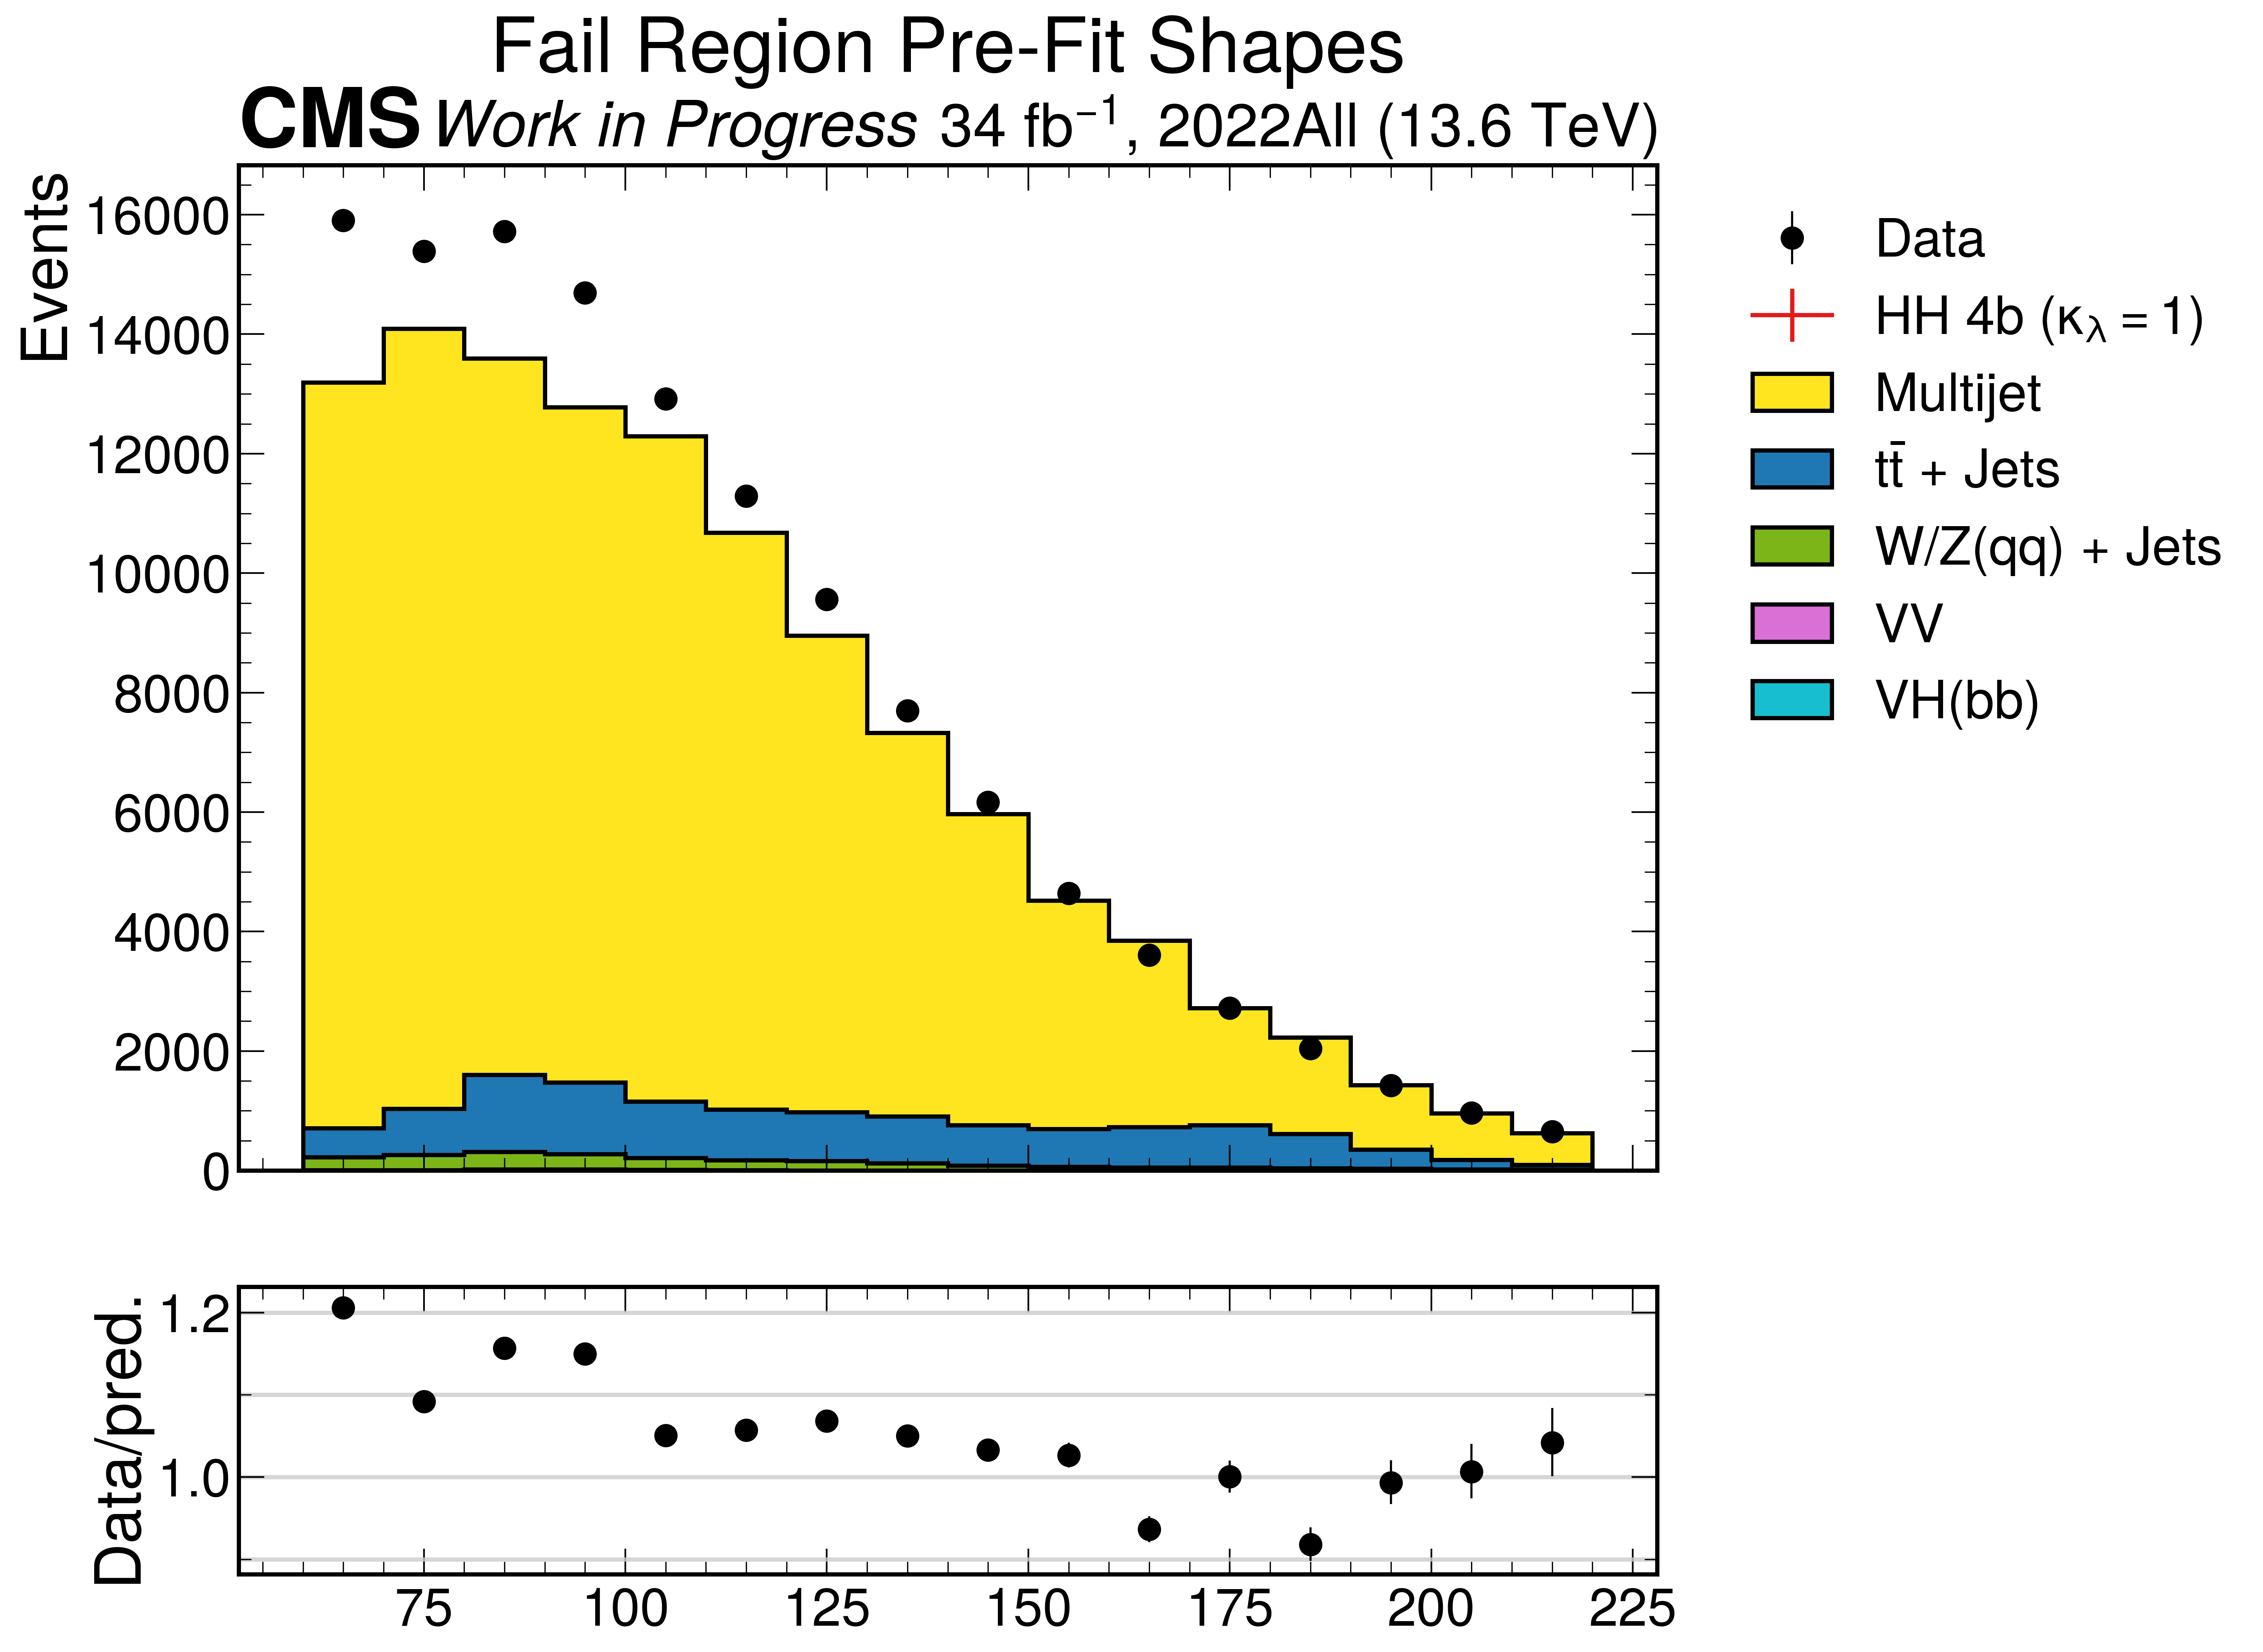

In [15]:
txbb_cut = 0.95

selection_regions = {
    "pass": Region(
        cuts={
            "H1Xbb": [txbb_cut, 1],
            "H2Xbb": [txbb_cut, 1],
            "H1Msd": [100, 150],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H1Xbb": [0, txbb_cut],
            "H2Xbb": [0, txbb_cut],
            "H1Msd": [100, 150],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [16, 60, 220],
    reg=True,
    blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24-cutbased/"
year = "2022All"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined,
    bb_masks=None,
    year="2022All",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)

Adding Run-3 data

In [16]:
events_dict_bdt["2022EE"].keys()

dict_keys(['ttbar', 'hh4b', 'data', 'novhhtobb', 'qcd', 'vhtobb', 'vbfhh4b', 'diboson', 'vjets'])

In [17]:
# create combined datasets
lumi_weight_2022EEtoall = (7971.4 + 26337.0 + 17650.0 + 9451.0) / 26337.0

events_dict_bdt_combined_2023 = {}
for key in ["data", "hh4b", "qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"]:
    if key == "data":
        combined = pd.concat(
            [
                events_dict_bdt["2022"][key],
                events_dict_bdt["2022EE"][key],
                events_dict_bdt["2023-pre-BPix"][key],
                events_dict_bdt["2023-BPix"][key],
            ]
        )
    else:
        combined = events_dict_bdt["2022EE"][key].copy()
        combined["weight"] = combined["weight"] * lumi_weight_2022EEtoall
    events_dict_bdt_combined_2023[key] = combined

In [18]:
17650.0 + 9451.0

27101.0

In [19]:
for xbb_cut in [0.8, 0.9, 0.95, 0.98]:
    figure_of_merits = []
    cuts = []
    for bdt_cut in np.arange(0.01, 1, 0.01):
        nevents_data = get_nevents_data(events_dict_bdt_combined_2023["data"], xbb_cut, bdt_cut)
        nevents_signal = get_nevents_signal(events_dict_bdt_combined_2023["hh4b"], xbb_cut, bdt_cut)

        figure_of_merit = 2 * np.sqrt(nevents_data) / nevents_signal

        if nevents_signal > 0.5:
            cuts.append(bdt_cut)
            figure_of_merits.append(figure_of_merit)
            print(
                f"Xbb_Cut: {xbb_cut}, BDT_Cut: {bdt_cut:.2f}, NBkg: {nevents_data}, NSig: {nevents_signal:.2f}, FOM: {figure_of_merit:.2f}"
            )

    if len(cuts) > 0:
        cuts = np.array(cuts)
        figure_of_merits = np.array(figure_of_merits)
        smallest = np.argmin(figure_of_merits)

        print(xbb_cut, cuts[smallest], figure_of_merits[smallest])

Xbb_Cut: 0.8, BDT_Cut: 0.01, NBkg: 582, NSig: 2.92, FOM: 16.54
Xbb_Cut: 0.8, BDT_Cut: 0.02, NBkg: 449, NSig: 2.90, FOM: 14.61
Xbb_Cut: 0.8, BDT_Cut: 0.03, NBkg: 374, NSig: 2.89, FOM: 13.38
Xbb_Cut: 0.8, BDT_Cut: 0.04, NBkg: 337, NSig: 2.88, FOM: 12.76
Xbb_Cut: 0.8, BDT_Cut: 0.05, NBkg: 303, NSig: 2.87, FOM: 12.13
Xbb_Cut: 0.8, BDT_Cut: 0.06, NBkg: 282, NSig: 2.86, FOM: 11.73
Xbb_Cut: 0.8, BDT_Cut: 0.07, NBkg: 260, NSig: 2.86, FOM: 11.28
Xbb_Cut: 0.8, BDT_Cut: 0.08, NBkg: 237, NSig: 2.85, FOM: 10.80
Xbb_Cut: 0.8, BDT_Cut: 0.09, NBkg: 217, NSig: 2.84, FOM: 10.36
Xbb_Cut: 0.8, BDT_Cut: 0.10, NBkg: 200, NSig: 2.84, FOM: 9.97
Xbb_Cut: 0.8, BDT_Cut: 0.11, NBkg: 192, NSig: 2.83, FOM: 9.79
Xbb_Cut: 0.8, BDT_Cut: 0.12, NBkg: 184, NSig: 2.82, FOM: 9.60
Xbb_Cut: 0.8, BDT_Cut: 0.13, NBkg: 174, NSig: 2.82, FOM: 9.36
Xbb_Cut: 0.8, BDT_Cut: 0.14, NBkg: 167, NSig: 2.82, FOM: 9.18
Xbb_Cut: 0.8, BDT_Cut: 0.15, NBkg: 153, NSig: 2.81, FOM: 8.80
Xbb_Cut: 0.8, BDT_Cut: 0.16, NBkg: 146, NSig: 2.80, FOM: 8.62

pass
bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']


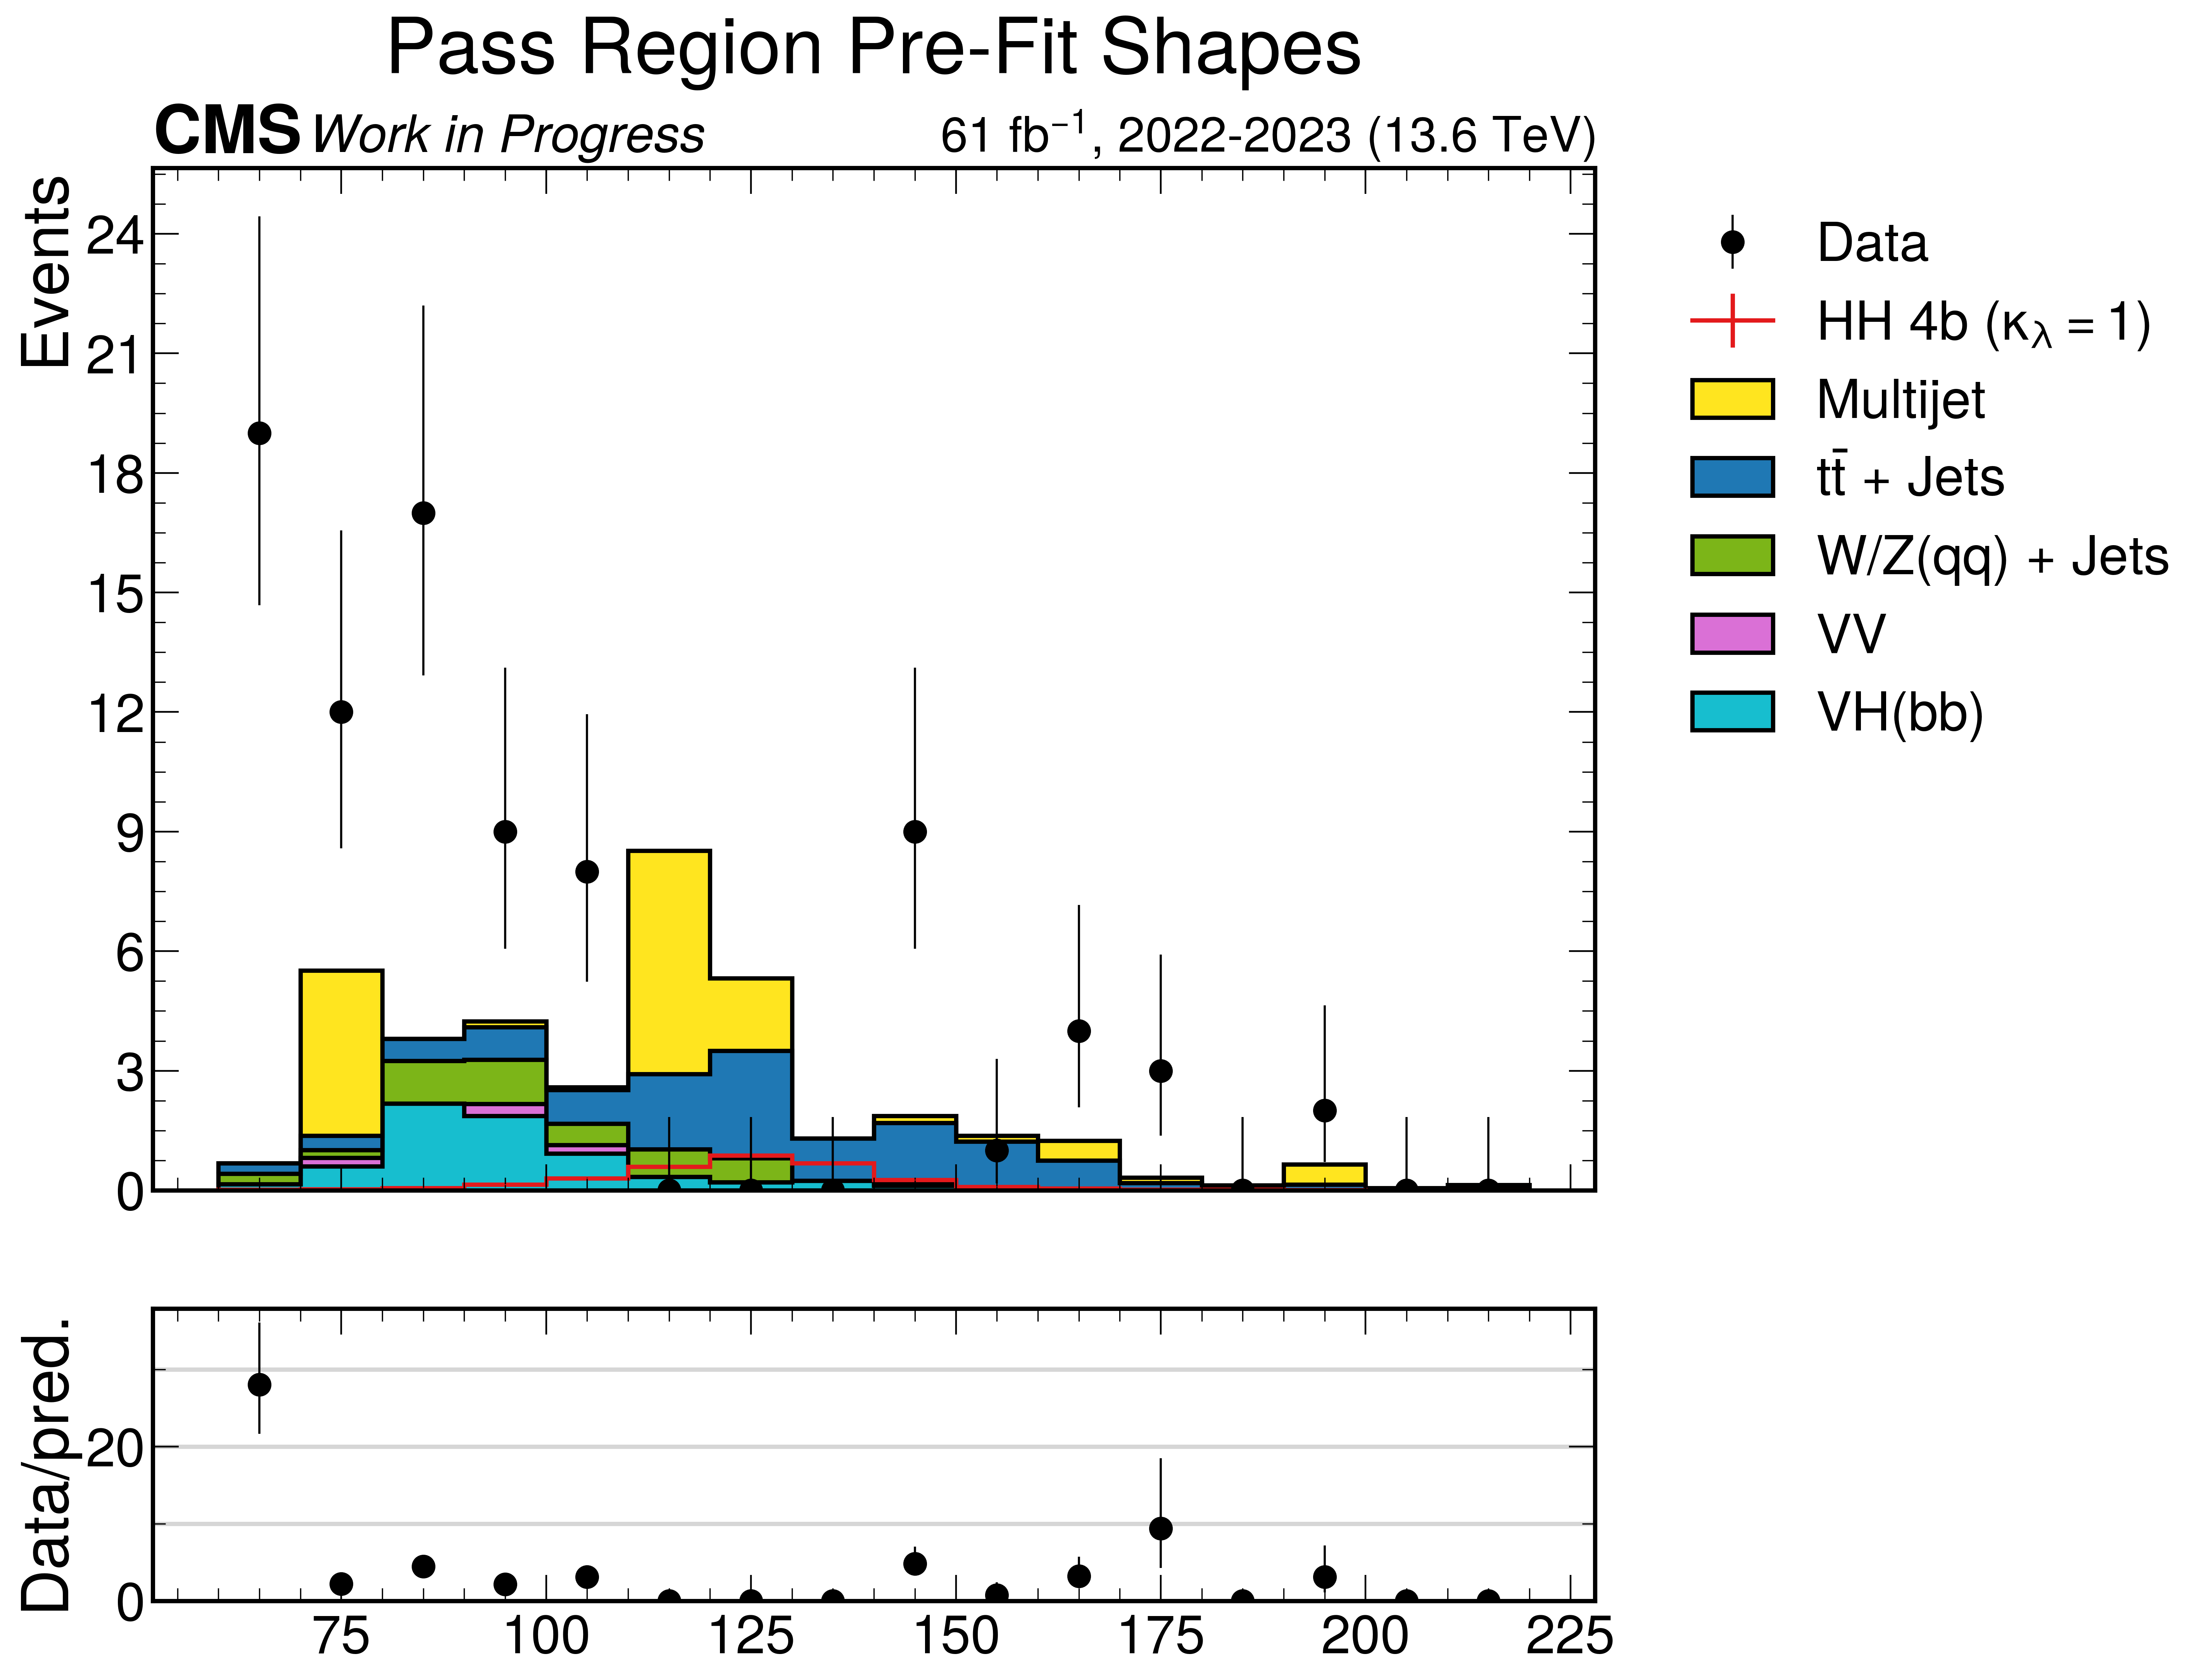

fail
bkg  ['vhtobb', 'diboson', 'vjets', 'ttbar', 'qcd']


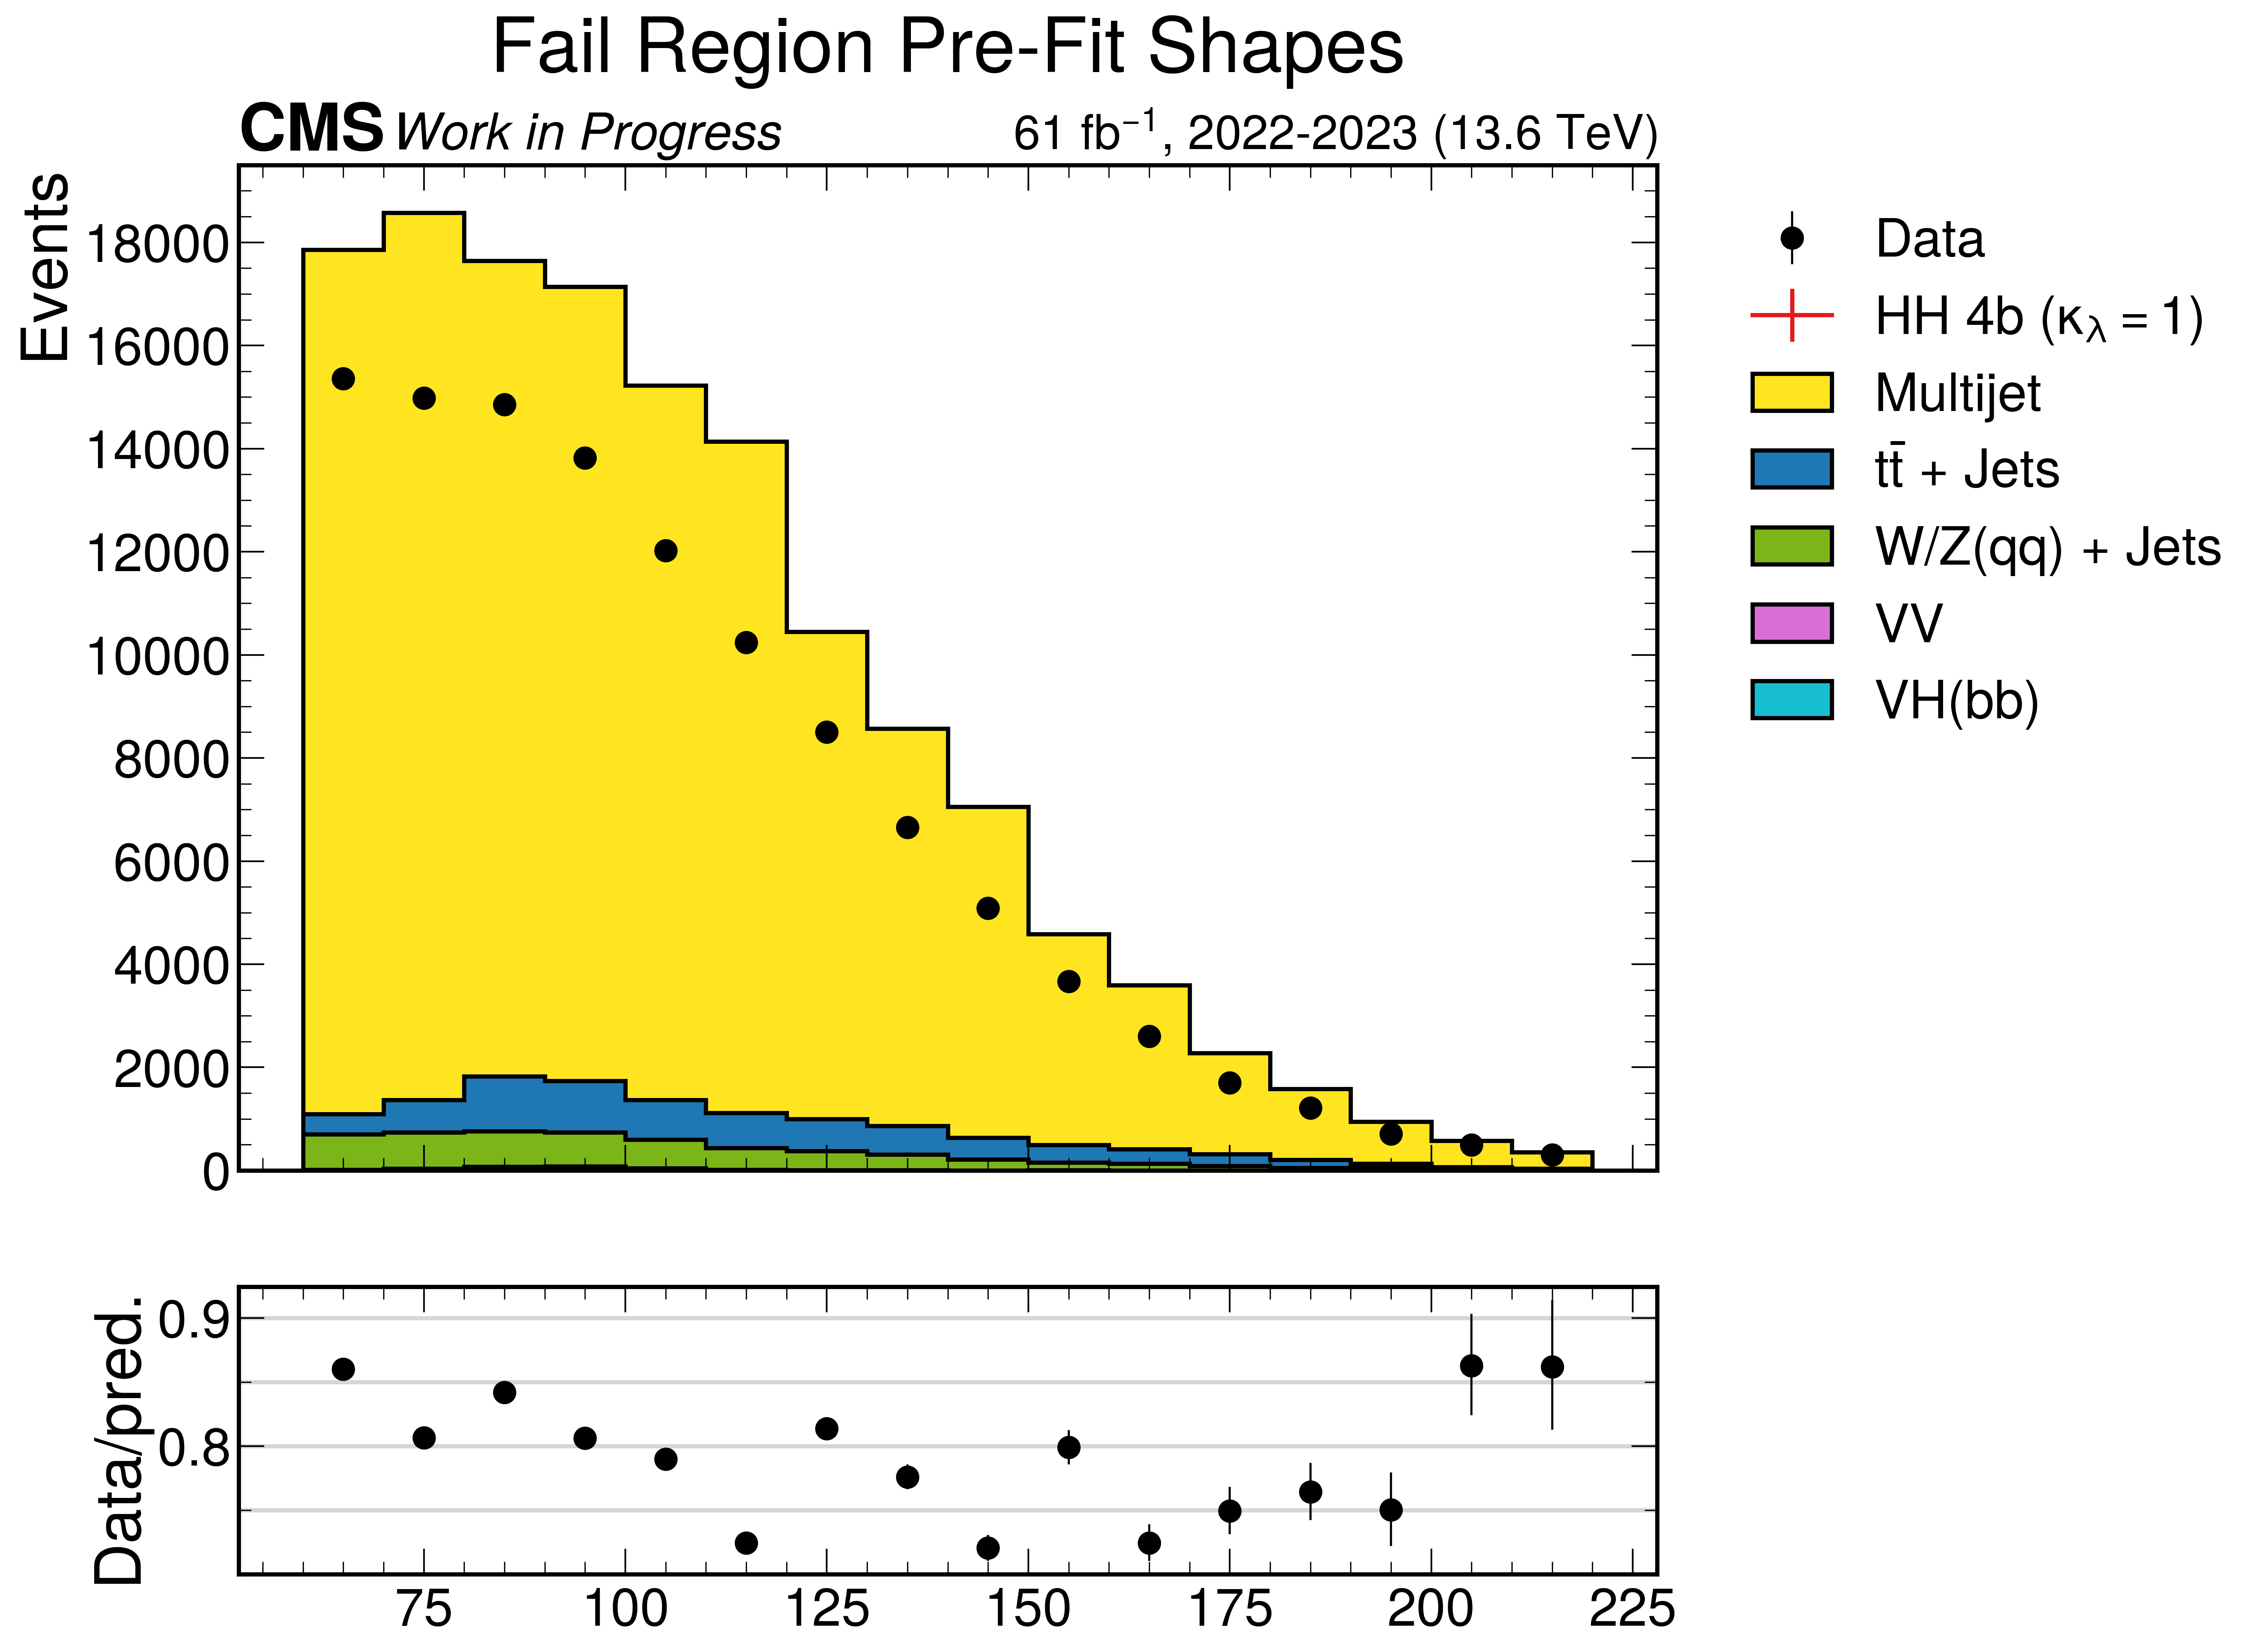

In [27]:
txbb_cut = 0.8
bdt_cut = 0.62

selection_regions = {
    "pass": Region(
        cuts={
            "H2Xbb": [txbb_cut, 1],
            "bdt_score": [bdt_cut, 1],
        },
        label="Pass",
    ),
    "fail": Region(
        cuts={
            "H2Xbb": [0, txbb_cut],
            "bdt_score": [0.03, 1],
        },
        label="Fail",
    ),
}

fit_shape_var = ShapeVar(
    "H2Msd",
    r"$m^{2}_\mathrm{SD}$ (GeV)",
    [16, 60, 220],
    reg=True,
    blind_window=[110, 140],
)

templ_dir = "./templates/15Mar24/"
year = "2022-2023"
os.system(f"mkdir -p {templ_dir}/{year}")
os.system(f"mkdir -p {templ_dir}/cutflows/{year}")

templates = postprocessing.get_templates(
    events_dict_bdt_combined_2023,
    bb_masks=None,
    year="2022-2023",
    sig_keys=["hh4b"],
    selection_regions=selection_regions,
    shape_vars=[fit_shape_var],
    systematics={},
    template_dir=f"{templ_dir}",
    bg_keys=["qcd", "ttbar", "vhtobb", "vjets", "diboson", "novhhtobb"],
    plot_dir=f"{templ_dir}/{year}",
    weight_key="weight",
    show=True,
    energy=13.6,
)